In [46]:
!pip install pyod -q 

In [47]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pyod.models.pca import PCA as pyod_PCA
import string
import datetime
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings("ignore")

In [48]:
# Авторизация гугл диска
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Здесь укажите путь к папке с ноутбуком и датасетом на гугл диске
%cd  /content/drive/MyDrive/

/content/drive/MyDrive


In [50]:
# создаем датасет для проверки функций
np.random.seed(42)
n = 600
assert_data = pd.DataFrame(columns=['id', 'member_id', 'issue_d', 'target', 'test_flg', 'atr_int_1', 'atr_int_2', 'atr_int_3', 'atr_cat_1', 'atr_cat_2', 'atr_cat_3'])
assert_data['id'] = range(n)
assert_data['member_id'] = range(n)
assert_data['issue_d'] = [datetime.datetime.strftime(datetime.date(2000,1,1) + relativedelta(months=d),'%Y-%m-%d') for d in range(60)] * int(n/60)
assert_data['target'] = [np.random.randint(2) for i in range(n)]
assert_data['test_flg'] = [np.random.randint(2) for i in range(n)]
for i in range(1, 4):
    assert_data[f'atr_int_{i}'] = np.random.random(n)
    assert_data[f'atr_cat_{i}'] = np.random.choice(' '.join(c for c in string.ascii_uppercase).split(), n)

assert_tech_columns = ['id', 'member_id', 'issue_d', 'target']
assert_interrval_features = [f'atr_int_{i}' for i in range(1, 4)]
assert_category_features = [f'atr_cat_{i}' for i in range(1, 4)]

assert_data.head()

,id,member_id,issue_d,target,test_flg,atr_int_1,atr_int_2,atr_int_3,atr_cat_1,atr_cat_2,atr_cat_3
0,0,0,2000-01-01,0,0,0.168935,0.302061,0.737870,L,Q,N
1,1,1,2000-02-01,1,1,0.278590,0.731958,0.834145,G,E,C
2,2,2,2000-03-01,0,1,0.177010,0.851174,0.740476,K,L,J
3,3,3,2000-04-01,0,1,0.088703,0.671425,0.142850,A,K,F
4,4,4,2000-05-01,0,0,0.120636,0.809530,0.753428,F,O,A


# Загрузка данных

Описание полей датасета в файле: Описание_полей_ru.xlsx

In [51]:
data_backup = pd.read_csv('./dataset_2_in.csv')
print(data_backup.shape)
data_backup.head(2)

(466285, 72)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,target
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [52]:
data = data_backup.copy()

In [53]:
data.shape, len(data['id'].drop_duplicates()), len(data['member_id'].drop_duplicates())

((466285, 72), 466285, 466285)

# Preprocessing данных

In [54]:
# преобразование формата даты
 
data['issue_d'] = pd.to_datetime(data['issue_d'], format = '%b-%y')
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], format = '%b-%y')
data['last_pymnt_d'] = pd.to_datetime(data['last_pymnt_d'], format = '%b-%y')
data['last_credit_pull_d'] = pd.to_datetime(data['last_credit_pull_d'], format = '%b-%y')
data['next_pymnt_d'] = pd.to_datetime(data['next_pymnt_d'], format = '%b-%y')

In [55]:
data.shape

(466285, 72)

## Task 0. Удаление плохих переменных

Познакомьтесь с описанием полей таблицы в файле LCDataDictionary.xlsx.

Выпишите те атрибуты, которые не могут принимать участие в моделировании, объясните свой выбор.

Рассмотрим корреляцию признаков с таргетом и проанализируем описание признаков.

In [56]:
data.corr().sort_values('target')['target']

total_rec_prncp               -0.253875
total_pymnt_inv               -0.195169
total_pymnt                   -0.194438
last_pymnt_amnt               -0.168030
out_prncp                     -0.158676
out_prncp_inv                 -0.158662
member_id                     -0.096759
id                            -0.095883
tot_cur_bal                   -0.051197
annual_inc                    -0.049864
total_rev_hi_lim              -0.037165
total_rec_int                 -0.026726
total_acc                     -0.023069
revol_bal                     -0.018348
pub_rec                       -0.009111
open_acc                      -0.006174
collections_12_mths_ex_med    -0.005114
mths_since_last_major_derog   -0.003873
mths_since_last_delinq        -0.003338
tot_coll_amt                  -0.001209
acc_now_delinq                -0.000197
delinq_2yrs                    0.001227
funded_amnt_inv                0.007191
funded_amnt                    0.011003
loan_amnt                      0.011819


In [57]:
# Удаление списка плохих атрибутов
bad_features = ['url', #URL адрес не играет роли в предсказании
                'zip_code', #почтовый код, не является драйвером, характеризующим клиента
                'addr_state', #адрес, в общем то, также не характеризует клиента
                'desc', #описание кредита от самого заемщика, пожалуй, не столь существенно
                'next_pymnt_d', #день следующей выплаты
                'policy_code' #информация про новые продукты, не так важна для оценки клиента
                # существуют и признаки с минимальными по модулю коэффициентами корреляции, но они имеют смысл количества счетов, по которым клиент просрочен на данный момент,
                # число прострочек за период времени и т. д., т. е. это важная информация

                
                # YOU CODE HERE
                
]
# Добавляем в плохие атрибуты даты
bad_features = set(bad_features)
for col in data.select_dtypes(include='datetime64[ns]').columns:
    bad_features.add(col)
bad_features = list(bad_features)
# Удаляем из списка плохих атрибутов атрибут 'issue_d', так как это техническое поле
bad_features.remove('issue_d')
print(f"Количество плохих атрибутов: {len(bad_features)}")

# Список технических полей
tech_columns = ['id', 'member_id', 'issue_d', 'target']
print(f"Количество технических атрибутов: {len(tech_columns)}")

# Список категориальных атрибутов
category_features = []
for col in data.select_dtypes(include='object').columns:
    category_features.append(col)
category_features = list(set(category_features) - set(bad_features))
print(f"Количество категориальных атрибутов: {len(category_features)}")

# Список интервальных атрибутов
interrval_features = list(set(data.columns) - set(tech_columns) - set(category_features) - set(bad_features))
print(f"Количество интервальных атрибутов: {len(interrval_features)}")

# Список всех атрибутов: категориальные + интервальные
features = interrval_features + category_features
print(f"Общее количество атрибутов: {len(features)}")

Количество плохих атрибутов: 9
Количество технических атрибутов: 4
Количество категориальных атрибутов: 12
Количество интервальных атрибутов: 47
Общее количество атрибутов: 59


## Task 1. Кодирование категориальных переменных

> Реализуйте функцию, которая кодирует категориальные переменные в датасете, используя LabelEncoding

> При реализации функции учтите следующее:
* В данном случае у нас нет необходимости делить выборку на train\test перед кодированием, поскольку все категориальные данные клиент выбирает из ограниченного списка, поэтому кодирование производим на всей выборке до деления на train\test

> Описание функции:
* На вход принимает:
1. Датасет со всеми атрибутами, техническими столбцами и целевым событием
2. Список категориальных атрибутов
* Возвращает следующее:
1. Датасет, в котором все категориальные переменные закодированы, при этом имена столбцов с категориальными переменными не меняются
2. Словарь, ключами которого являются названия столбцов категориальных переемнных, а значениями np.array с двумя столбцами:
* Первый столбец - значение категориального атрибута
* Второй столбец - численное значение, соответствующее значению категориального атрибута


In [58]:
from sklearn.preprocessing import LabelEncoder

def prepare_categorial_attributes(data_, category_columns_):
    # YOU CODE HERE
    label_encoder = LabelEncoder()
    res = data_.copy()
    d = {}
    for category_column in category_columns_:
        res[category_column] = label_encoder.fit_transform(res[category_column])
        classes = np.reshape(label_encoder.classes_, (len(label_encoder.classes_), 1))
        labels = label_encoder.transform(classes)
        labels = np.reshape(labels, (len(labels), 1))
        table = np.concatenate((classes, labels), axis=1)
        d[category_column] = table
    return res, d

In [59]:
# Проверяем реализацию функции
assert_data_transformed, assert_dct_cat_labels = prepare_categorial_attributes(data_ = assert_data, category_columns_ = assert_category_features)

assert assert_data_transformed.shape == assert_data.shape
assert sum(assert_data_transformed[assert_category_features].dtypes == 'int64') == len(assert_category_features)
assert len(assert_dct_cat_labels) == len(assert_category_features)
for col in assert_category_features:
    assert assert_dct_cat_labels[col].shape == (assert_data[col].nunique(), 2)

In [60]:
# Применяем функцию к целевой таблице
data_transformed, dct_cat_labels = prepare_categorial_attributes(data_ = data, category_columns_ = category_features)

# Формирование train и test dataframes для моделирования

Отобразим зависимость доли популяции и уровня дефолта от даты подачи заявки

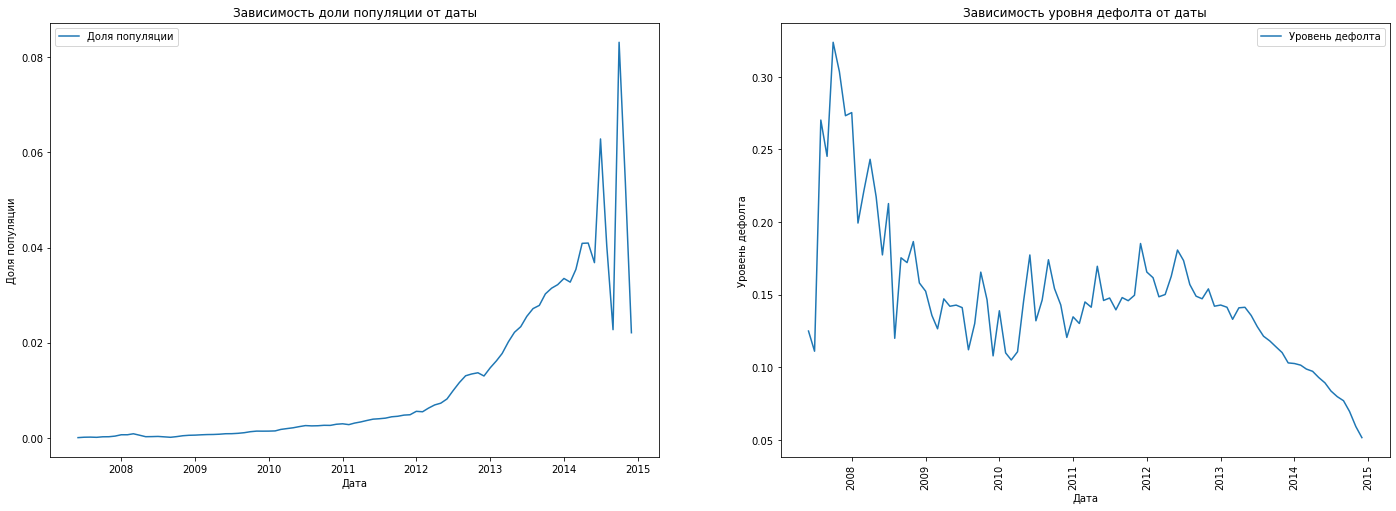

In [61]:
# Функция визуализации доли популяции и уровня дефолта
def draw_pop_def_rate(data_):
    temp = data_.groupby('issue_d').agg({'id' : 'count', 'target' : 'mean'})

    # Визуализация
    fig = plt.figure(figsize=(24,8))
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)

    ax_1.set_title('Зависимость доли популяции от даты')
    ax_1.plot(temp.index, temp['id']/temp['id'].sum(), label='Доля популяции')
    plt.xticks( rotation=90)
    ax_1.set_xlabel('Дата')
    ax_1.set_ylabel('Доля популяции')
    ax_1.legend()

    ax_2.set_title('Зависимость уровня дефолта от даты')
    ax_2.plot(temp.index, temp['target'], label='Уровень дефолта')
    plt.xticks(rotation=90)
    ax_2.set_xlabel('Дата')
    ax_2.set_ylabel('Уровень дефолта')
    ax_2.legend()

    plt.show()


draw_pop_def_rate(data_ = data_transformed.copy())

# Task 2. Определение границы разделения на train/test

Поскольку наша модель будет применяться в будущем на новых клиентах, то деление на train\test будем производить только по временной метке. 

> Реализуйте функцию, которая для каждого возможного месяца деления на train\test возвращает долю популяции и уровень дефолта в каждой выборке

> Описание функции:
* На вход принимает:
1. Датасет со всеми атрибутами, техническими столбцами и целевым событием
* Возвращает pandas DataFrame со следующими столбцами:
1. month - месяц деления на train\test
2. qnt_rate_train - доля популяции train выборки
3. qnt_rate_test - доля популяции test выборки
4. default_rate_train - уровень дефолта train выборки
5. default_rate_test - уровень дефолта test выборки

In [62]:
def possible_train_test_division(data_):
    # YOU CODE HERE
    months = data_['issue_d'].apply(lambda x : pd.Timestamp(x).strftime('%m/%Y')).unique()

    out = []
    for month in months:
        date = pd.Timestamp(f'01/{month}')
        train = data_[data_['issue_d'].apply(lambda x : pd.Timestamp(x)) > month]
        test = data_[data_['issue_d'].apply(lambda x : pd.Timestamp(x)) <= month]

        train_temp = train.groupby('issue_d').agg({'id' : 'count', 'target' : 'mean'})
        test_temp = test.groupby('issue_d').agg({'id' : 'count', 'target' : 'mean'})

        train_pop_rate = train_temp['id'].sum() / (train_temp['id'].sum() + test_temp['id'].sum())
        test_pop_rate = test_temp['id'].sum() / (train_temp['id'].sum() + test_temp['id'].sum())

        train_pd = train_temp['target'].mean()
        test_pd = test_temp['target'].mean() 

        out.append(
            {'month': month,
            'qnt_rate_train': test_pop_rate, 
            'qnt_rate_test': train_pop_rate, 
            'default_rate_train': test_pd, 
            'default_rate_test': train_pd})
        
    return pd.DataFrame(out)
    

In [63]:
# Проверяем реализацию функции
assert_possible_division_dataset = possible_train_test_division(data_ = assert_data_transformed.copy())

assert assert_possible_division_dataset.shape == (60, 5)
assert set(assert_possible_division_dataset.columns) == {'default_rate_test', 'default_rate_train', 'month', 'qnt_rate_test', 'qnt_rate_train'}
assert round(assert_possible_division_dataset['default_rate_test'].sum(), 5) == 32.10218
assert round(assert_possible_division_dataset['default_rate_train'].sum(), 5) == 28.79368
assert round(assert_possible_division_dataset['qnt_rate_test'].sum(), 5) == 29.5
assert round(assert_possible_division_dataset['qnt_rate_train'].sum(), 5) == 30.5

In [64]:
# Применяем функцию к целевой таблице
possible_division_dataset = possible_train_test_division(data_ = data_transformed.copy())

Визуализируем результаты возможных разбиений

In [65]:
def make_test_flg(data_, part):
    month_list = list(data_.sort_values('issue_d')['issue_d'].drop_duplicates())
    month_num = round(part * len(month_list))
    data_['test_flg'] = np.where(data_['issue_d'] > month_list[month_num], 1, 0)
    print(f'Месяц деления на train test: {month_list[month_num]}')
    return data_

In [66]:
def draw_possible_train_test_split(data_, possible_division_dataset):

    # Проставляем флаг тестовой выборки
    month_split = data_[data_['test_flg']==1]['issue_d'].min()

    # Визуализация
    fig = plt.figure(figsize=(48, 20))
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)

    ax_1.set_title('Доля популяции train и test выборок')
    ax_1.plot(possible_division_dataset['month'], possible_division_dataset['qnt_rate_train'], label='train')
    ax_1.plot(possible_division_dataset['month'], possible_division_dataset['qnt_rate_test'], label='test')
    #ax_1.axvline(month_split, color='red', ls='--', label=f'test split')
    plt.xticks( rotation=90)
    ax_1.set_xlabel('Дата разделения на train/test')
    ax_1.set_ylabel('Доля популяции')
    ax_1.legend()

    ax_2.set_title('Уровень дефолта train и test выборок')
    ax_2.plot(possible_division_dataset['month'], possible_division_dataset['default_rate_train'], label='train')
    ax_2.plot(possible_division_dataset['month'], possible_division_dataset['default_rate_test'], label='test')
    #ax_2.axvline(month_split, color='red', ls='--', label=f'test split')
    plt.xticks(rotation=90)
    ax_2.set_xlabel('Дата разделения на train/test')
    ax_2.set_ylabel('Уровень дефолта')
    ax_2.legend()

    plt.show()

Месяц деления на train test: 2014-04-01 00:00:00


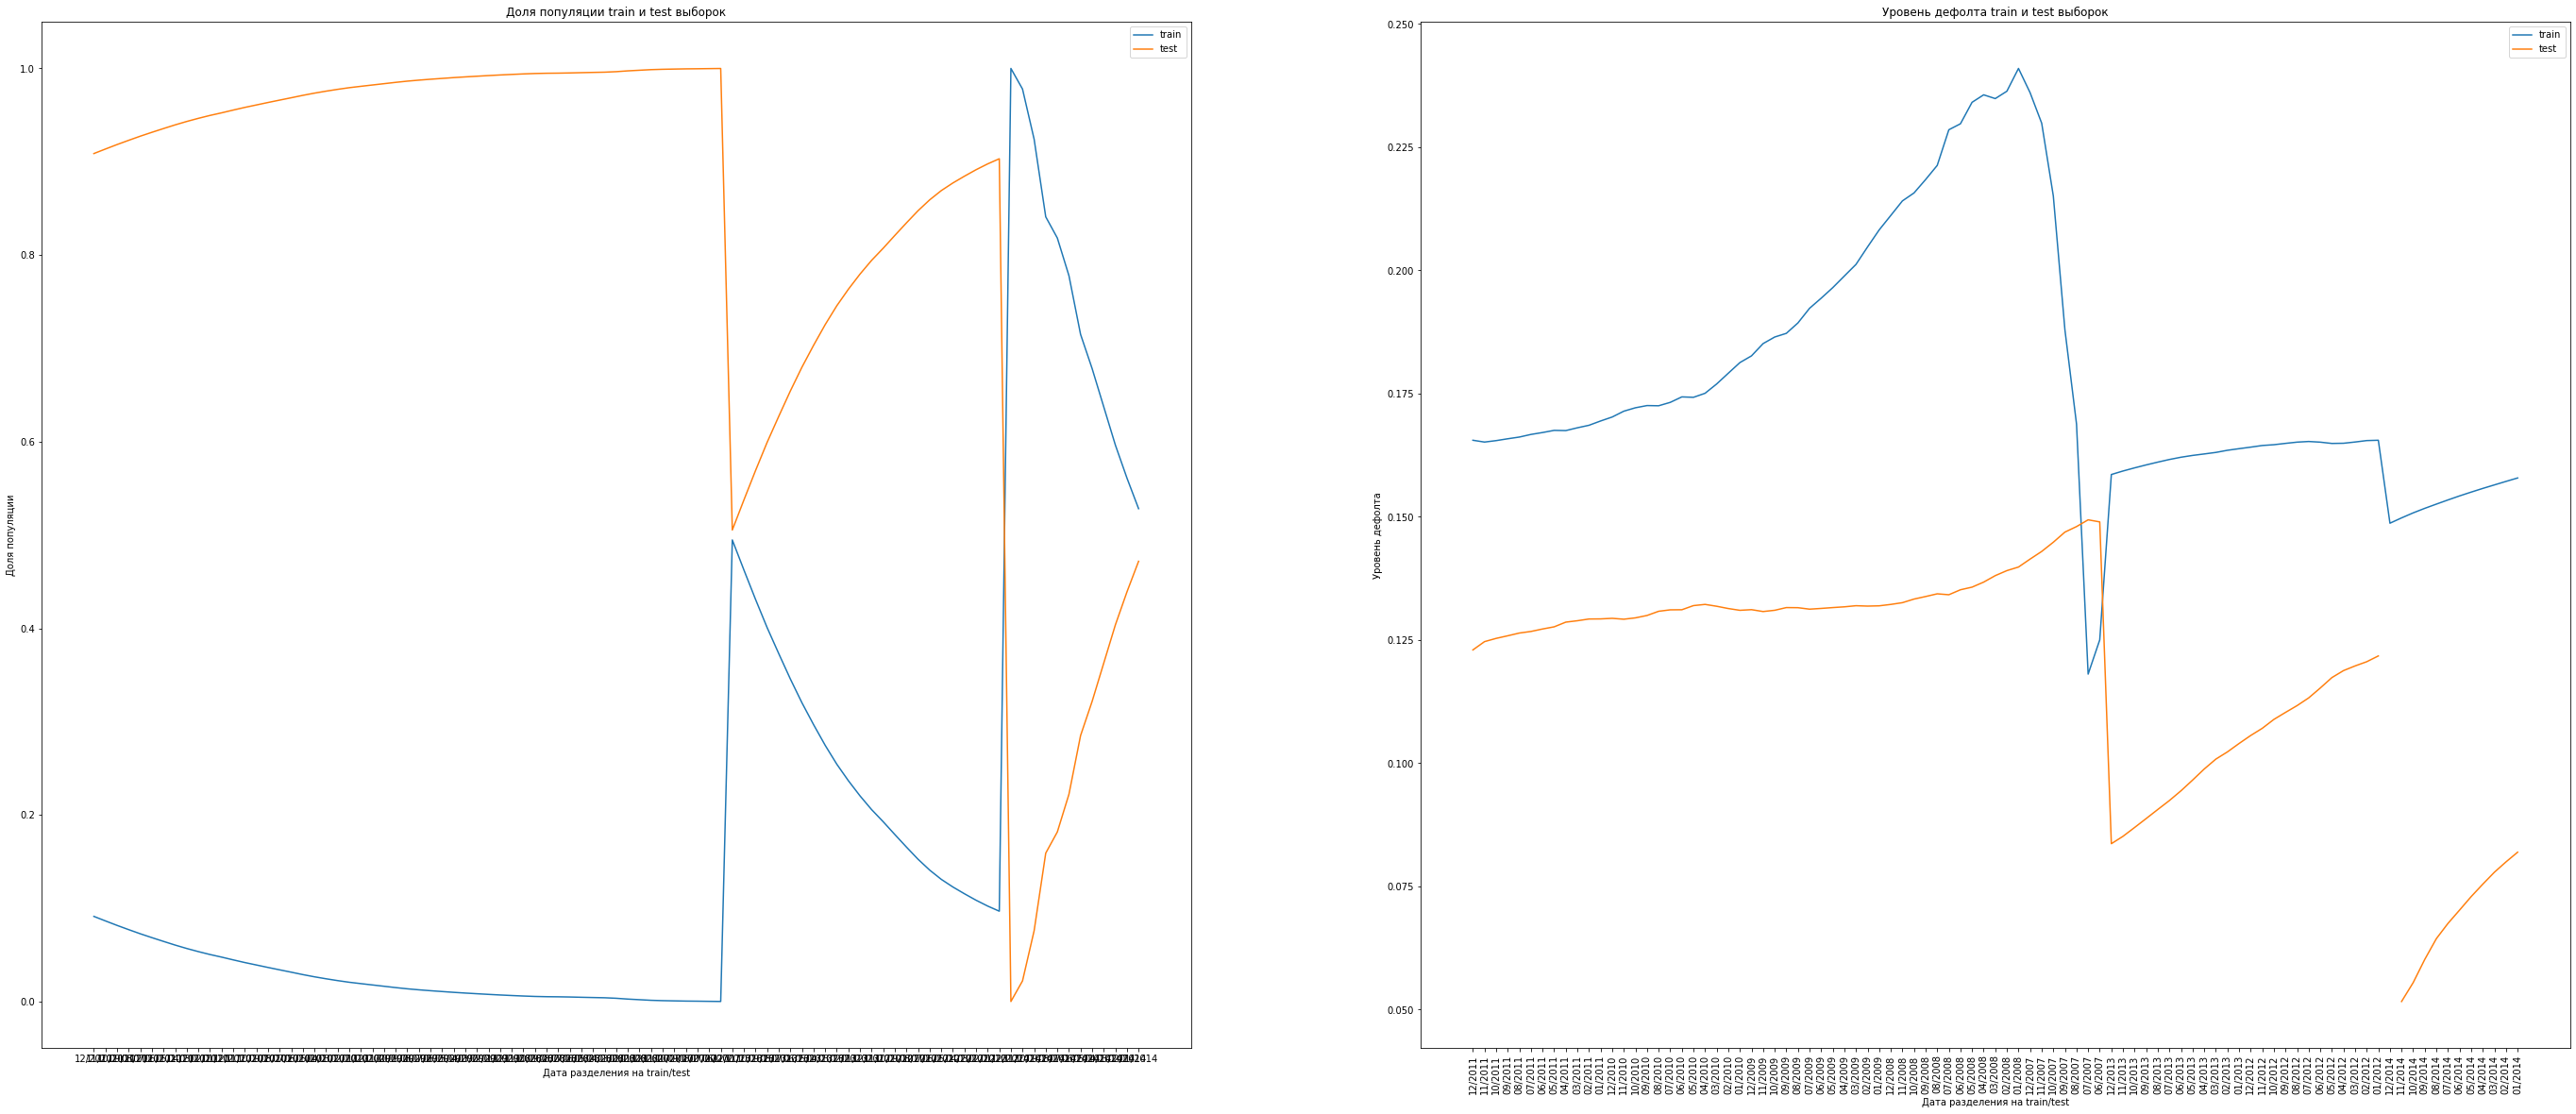

In [67]:
part = 0.9
data_transformed = make_test_flg(data_ = data_transformed, part = part)
draw_possible_train_test_split(data_ = data_transformed, possible_division_dataset = possible_division_dataset.copy())

In [68]:
# Информация о разделении на train и test
def information_train_test(data_):
    temp = data_.groupby('test_flg').agg({'id' : 'count', 'target' : ['mean', 'sum']})
    temp.columns = ['Кол-во наблюдений', 'Уровень дефолта', 'Кол-во дефолтных наблюдений']
    temp['Доля популяции'] = temp['Кол-во наблюдений'] / data_.shape[0]
    return temp

data_transformed = make_test_flg(data_ = data_transformed, part = part)
information_train_test(data_ = data_transformed.copy())    

Месяц деления на train test: 2014-04-01 00:00:00


,Кол-во наблюдений,Уровень дефолта,Кол-во дефолтных наблюдений,Доля популяции
test_flg,,,,
0,297138,0.128452,38168,0.637245
1,169147,0.075674,12800,0.362755


## TASK 2.1 Определение границ

Исходя из графика распределения доли популяции и помесячного дефолта выберете оптимальные границы выборки для разработки и выборки для применения.

* start_date - дата начала выборки
* end_date - конец выборки
* test_start_date - дата деления на train и test

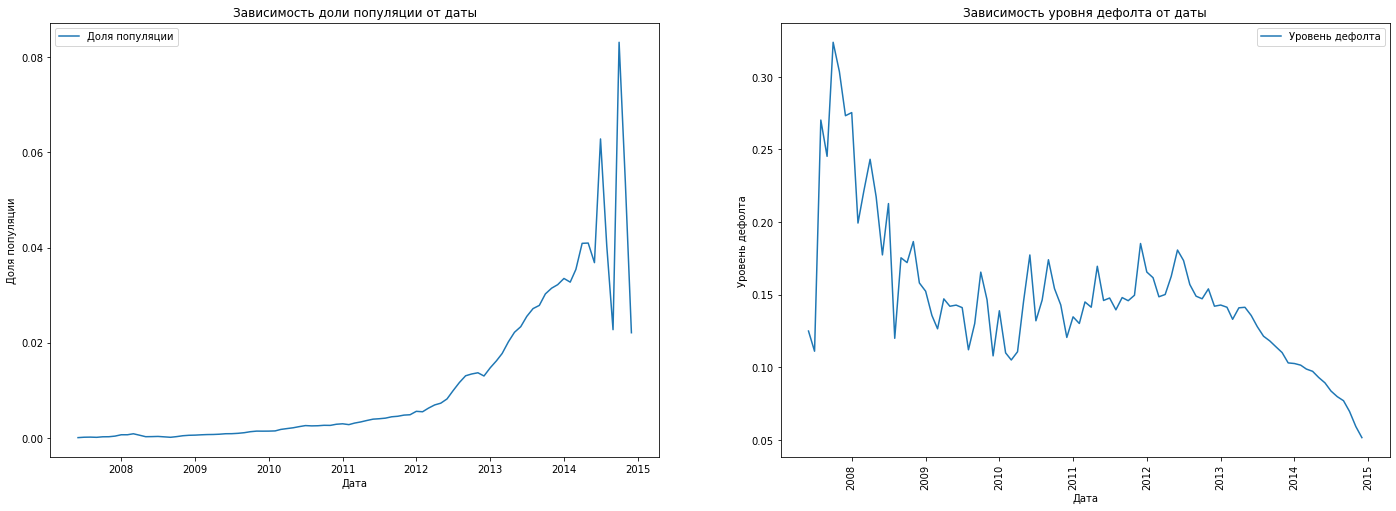

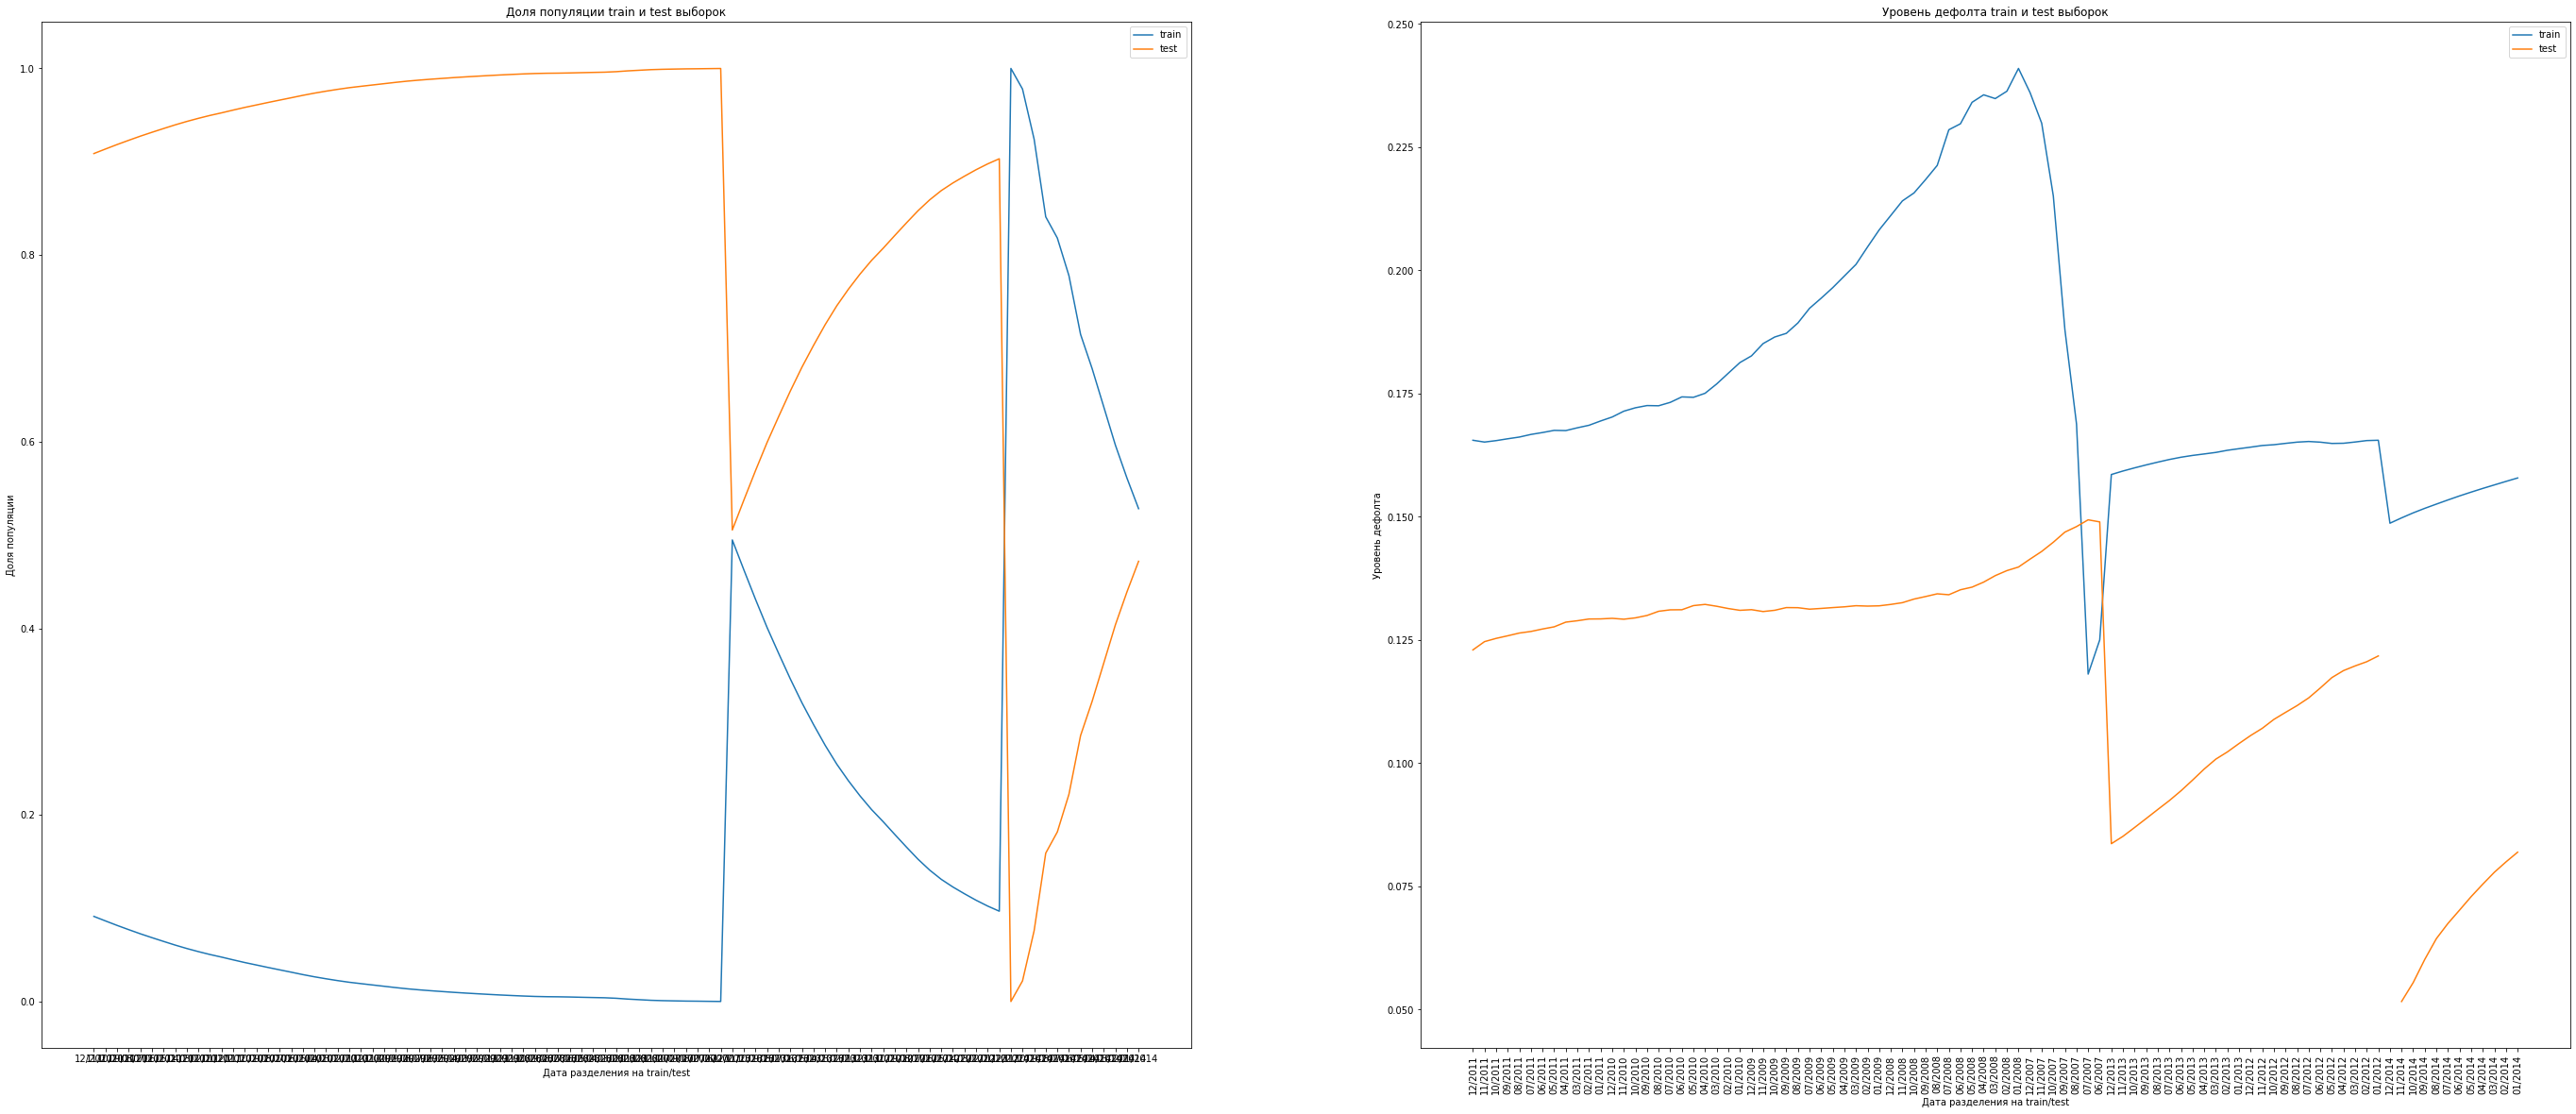

,Кол-во наблюдений,Уровень дефолта,Кол-во дефолтных наблюдений,Доля популяции
test_flg,,,,
0,278067,0.130591,36313,0.596346
1,188218,0.077862,14655,0.403654


In [69]:
# Подбираем границы исходя из цели предоставления наиболее подходящих данных на обучении и тесте, чтобы в обучение вошло достатосное количество разных случаев.

start_date = pd.Timestamp('2007-01-01')
end_date = pd.Timestamp('2016-01-01')
test_start_date = pd.Timestamp('2014-04-01')


data_transformed_short = data_transformed[(data_transformed['issue_d'] > start_date) & \
                                          (data_transformed['issue_d'] < end_date)
                                          ]

# Доля популяции и уровень дефолта
draw_pop_def_rate(data_ = data_transformed_short.copy())

# Деление на train и test
data_transformed_short['test_flg'] = np.where(data_transformed_short['issue_d'] >= test_start_date, 1, 0)
possible_division_dataset_new = possible_train_test_division(data_ = data_transformed_short.copy())
draw_possible_train_test_split(data_ = data_transformed_short, 
                               possible_division_dataset = possible_division_dataset_new)

# Информация о разделении на train и test
information_train_test(data_ = data_transformed_short.copy()) 

Убедитесь, что в выборках достаточное количество наблюдений и поясните ваш выбор границ выборок.

In [70]:
data_transformed = data_transformed_short.copy()

Визуализируем также при выбранном разделении на train\test количество дефолтных, количество недефолтных наблюдений и уровень дефолта по годам, на train и test выборках

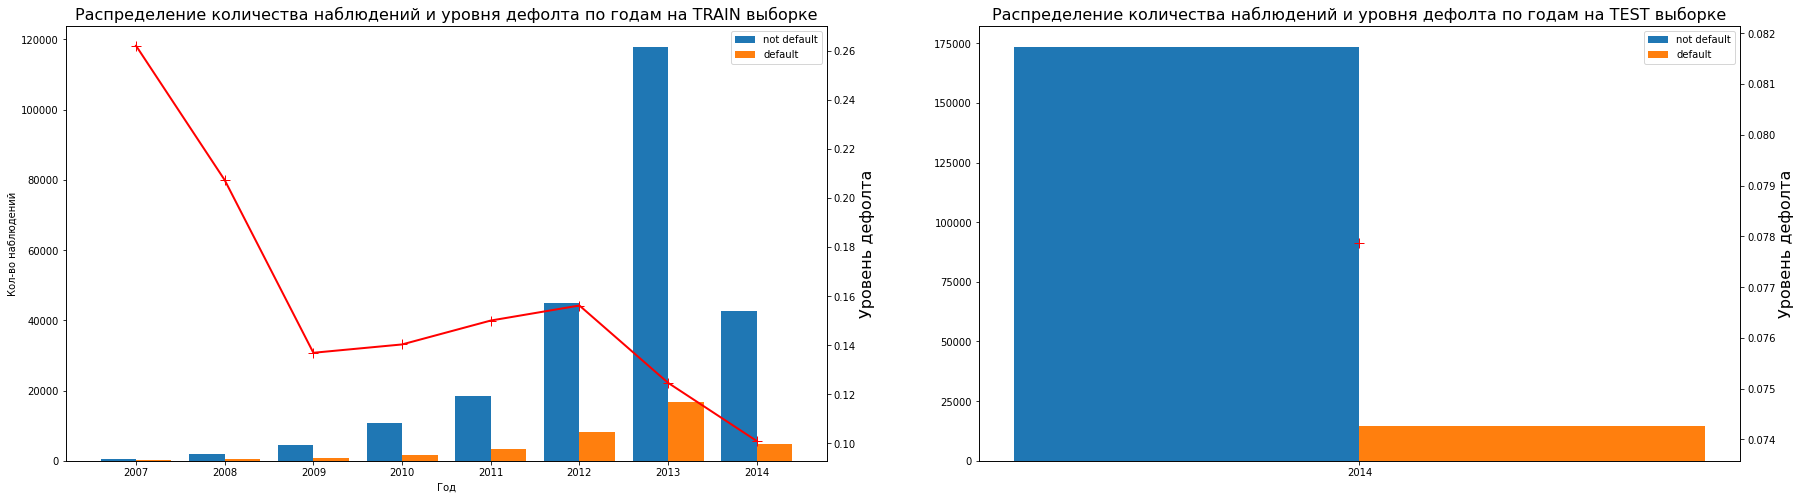

In [71]:
# Распределение количества наблюдений по годам
temp_data = data_transformed.copy()
temp_data['year'] = temp_data['issue_d'].apply(lambda x: x.year)
temp_train = temp_data[temp_data['test_flg']==0].copy()
temp_test = temp_data[temp_data['test_flg']==1].copy()
train_tar0 = temp_train[temp_train['target']==0].groupby('year').agg({'id' : 'count', 'target' : 'mean'})
train_tar1 = temp_train[temp_train['target']==1].groupby('year').agg({'id' : 'count', 'target' : 'mean'})
test_tar0 = temp_test[temp_test['target']==0].groupby('year').agg({'id' : 'count', 'target' : 'mean'})
test_tar1 = temp_test[temp_test['target']==1].groupby('year').agg({'id' : 'count', 'target' : 'mean'})


width = 0.4
fig = plt.figure(figsize=(30,8))

ax_1 = fig.add_subplot(1, 2, 1)
ax_2 = fig.add_subplot(1, 2, 2)

ind = np.arange(len(train_tar0.index))
ax_1.set_title('Распределение количества наблюдений и уровня дефолта по годам на TRAIN выборке', fontsize=16)
ax_1.set(xticks=ind + 0.5*width, xticklabels=train_tar0.index)
ax_1.bar(ind, train_tar0['id'], width, label='not default')
ax_1.bar(ind + width, train_tar1['id'], width, label='default')
ax_1.set_ylabel('Кол-во наблюдений')
ax_1.set_xlabel('Год')
ax_1.legend()

ax_1_ = ax_1.twinx()
ax_1_.plot(ind + 0.5*width, temp_train.groupby('year')['target'].mean(), '+-', linewidth=2, markersize=10, color='red')
ax_1_.set_ylabel('Уровень дефолта', fontsize=16)


ind = np.arange(len(test_tar0.index))
ax_2.set_title('Распределение количества наблюдений и уровня дефолта по годам на TEST выборке', fontsize=16)
ax_2.set(xticks=ind + 0.5*width, xticklabels=test_tar0.index)
ax_2.bar(ind, test_tar0['id'], width, label='not default')
ax_2.bar(ind + width, test_tar1['id'], width, label='default')
ax_2.legend()

ax_2_ = ax_2.twinx()
ax_2_.plot(ind + 0.5*width, temp_test.groupby('year')['target'].mean(), '+-', linewidth=2, markersize=10, color='red')
ax_2_.set_ylabel('Уровень дефолта', fontsize=16)

plt.show()

In [72]:
temp = temp_train.groupby('year').agg({'target':'mean', 'id':'count'}).merge(train_tar1['id'], how='left', left_index=True, right_index=True).merge(train_tar0['id'], how='left', left_index=True, right_index=True)
temp.columns = ['Уровень дефолта', 'Количество наблюдений', 'Количество дефолтных наблюдений', 'Количество недефолтных наблюдений']
temp

,Уровень дефолта,Количество наблюдений,Количество дефолтных наблюдений,Количество недефолтных наблюдений
year,,,,
2007,0.262023,603,158,445
2008,0.207271,2393,496,1897
2009,0.136906,5281,723,4558
2010,0.140305,12537,1759,10778
2011,0.150039,21721,3259,18462
2012,0.156164,53367,8334,45033
2013,0.124656,134755,16798,117957
2014,0.100949,47410,4786,42624


# Профилирование атрибутов

In [73]:
# Инофрмация об атрибутах на TRAIN 
data_transformed[data_transformed['test_flg']==0][features].describe().T

,count,mean,std,min,25%,50%,75%,max
int_rate,278067.0,13.963734,4.366931,5.42,10.990000,13.68000,16.7800,2.606000e+01
dti_joint,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tot_cur_bal,207791.0,137790.378351,150495.692758,0.00,27775.500000,81633.00000,208782.5000,8.000078e+06
open_il_24m,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revol_util,277829.0,56.706689,24.010461,0.00,39.900000,58.70000,75.7000,1.530000e+02
total_acc,278038.0,24.462253,11.307527,1.00,16.000000,23.00000,31.0000,1.050000e+02
delinq_2yrs,278038.0,0.243060,0.713481,0.00,0.000000,0.00000,0.0000,2.900000e+01
max_bal_bc,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_cu_tl,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acc_now_delinq,278038.0,0.002805,0.057953,0.00,0.000000,0.00000,0.0000,5.000000e+00


In [74]:
# Инофрмация об атрибутах на TEST 
data_transformed[data_transformed['test_flg']==1][features].describe().T

,count,mean,std,min,25%,50%,75%,max
int_rate,188218.0,13.630533,4.336128,6.00,10.4900,13.350,16.290,2.606000e+01
dti_joint,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tot_cur_bal,188218.0,139918.218279,153874.892886,0.00,29577.0000,81454.500,209183.000,4.026405e+06
open_il_24m,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
revol_util,188116.0,55.394570,23.294280,0.00,38.4000,56.000,73.200,8.923000e+02
total_acc,188218.0,25.953974,11.964069,2.00,17.0000,24.000,33.000,1.560000e+02
delinq_2yrs,188218.0,0.346157,0.903700,0.00,0.0000,0.000,0.000,2.200000e+01
max_bal_bc,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_cu_tl,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acc_now_delinq,188218.0,0.005770,0.081876,0.00,0.0000,0.000,0.000,4.000000e+00


In [75]:
# Наблюдаем пустые атрибуты
# Обновим список bad_features и списки: category_features и interval_features
empty_columns = []
for col in features:
    if str(data_transformed[col].mean()) == 'nan':
        empty_columns.append(col)
bad_features = bad_features + empty_columns
print(f"Количество плохих атрибутов: {len(bad_features)}")

# Список категориальных атрибутов
category_features = list(set(category_features) - set(bad_features))
print(f"Количество категориальных атрибутов: {len(category_features)}")

# Список интервальных атрибутов
interrval_features = list(set(data.columns) - set(tech_columns) - set(category_features) - set(bad_features))
print(f"Количество интервальных атрибутов: {len(interrval_features)}")

# Список всех атрибутов: категориальные + интервальные
features = interrval_features + category_features
print(f"Общее количество атрибутов: {len(features)}")

Количество плохих атрибутов: 24
Количество категориальных атрибутов: 12
Количество интервальных атрибутов: 32
Общее количество атрибутов: 44


Посмотрим на распределение атрибутов для дефолтных наблюдений и недефолтных наблюдений

Отображение распределений для атрибута: int_rate


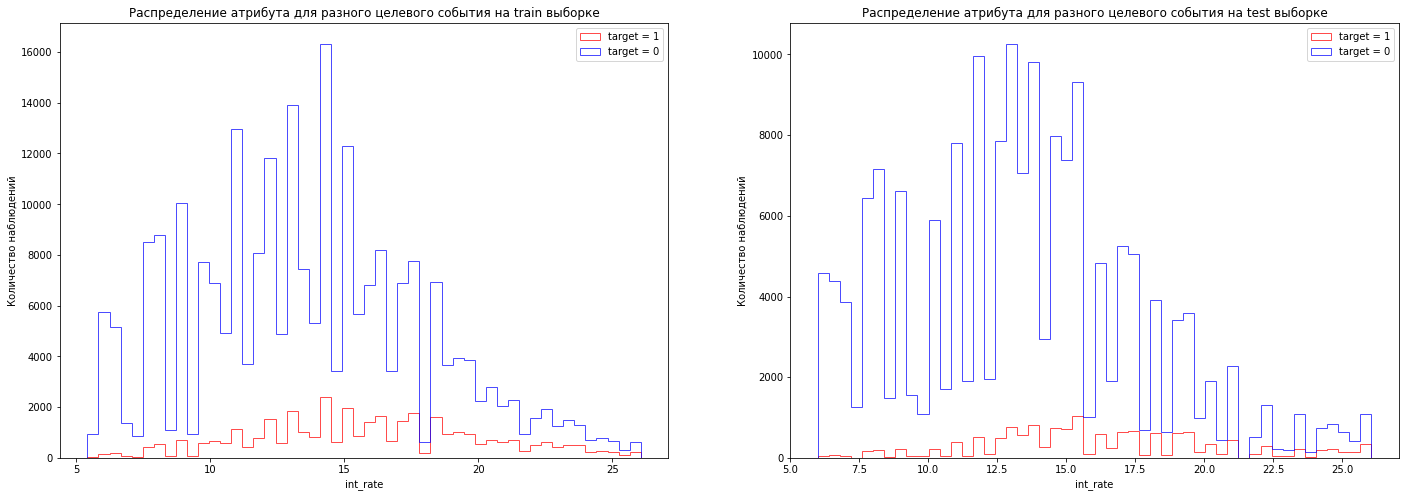


Отображение распределений для атрибута: tot_cur_bal


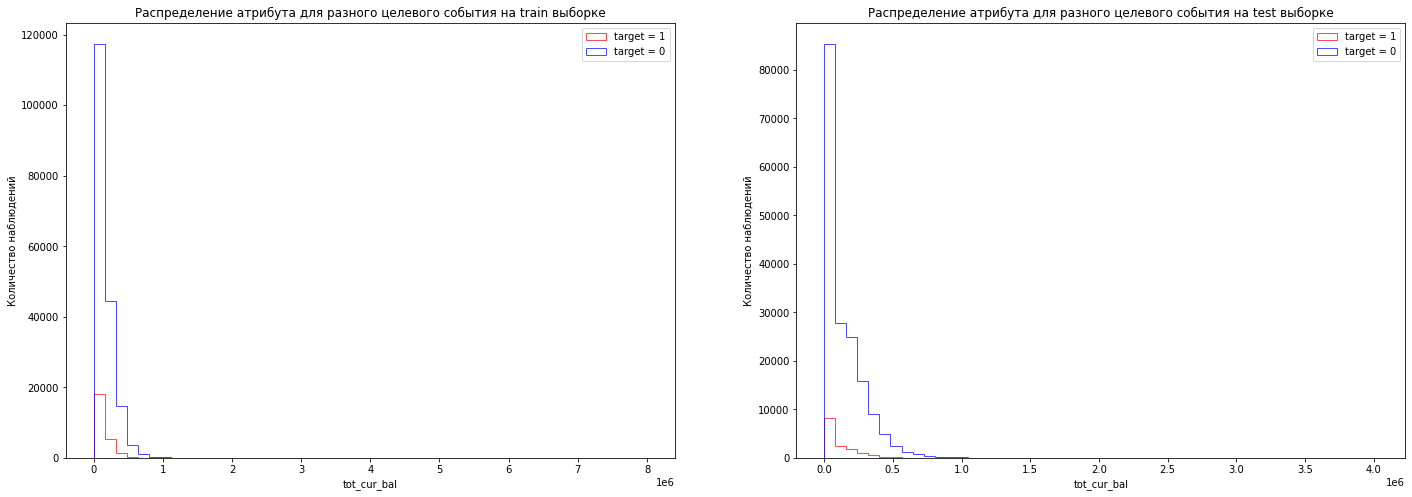


Отображение распределений для атрибута: revol_util


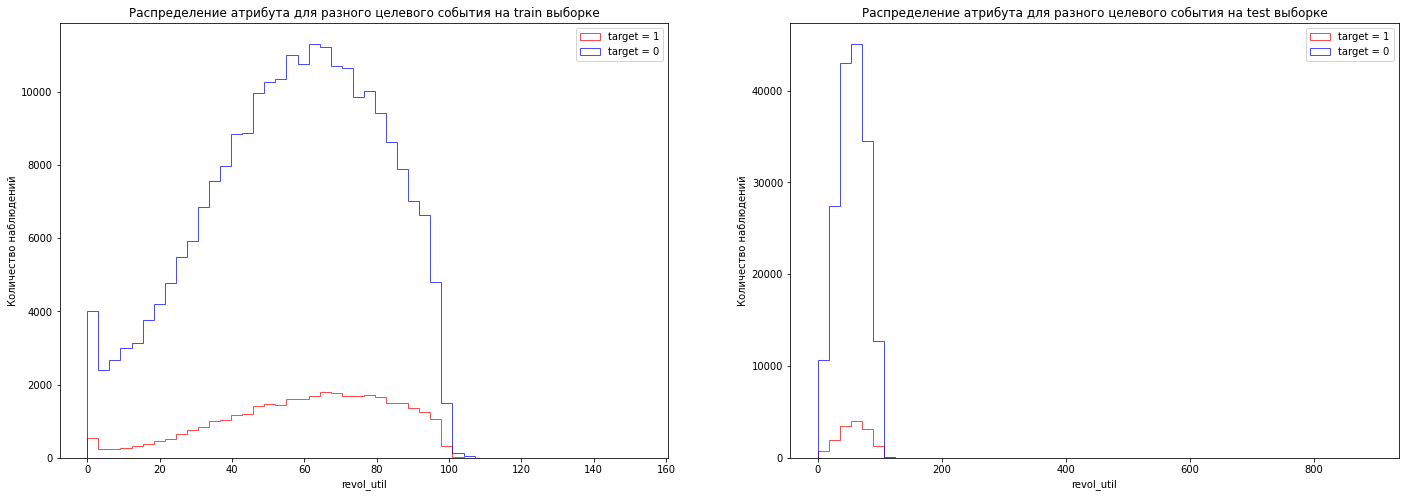


Отображение распределений для атрибута: total_acc


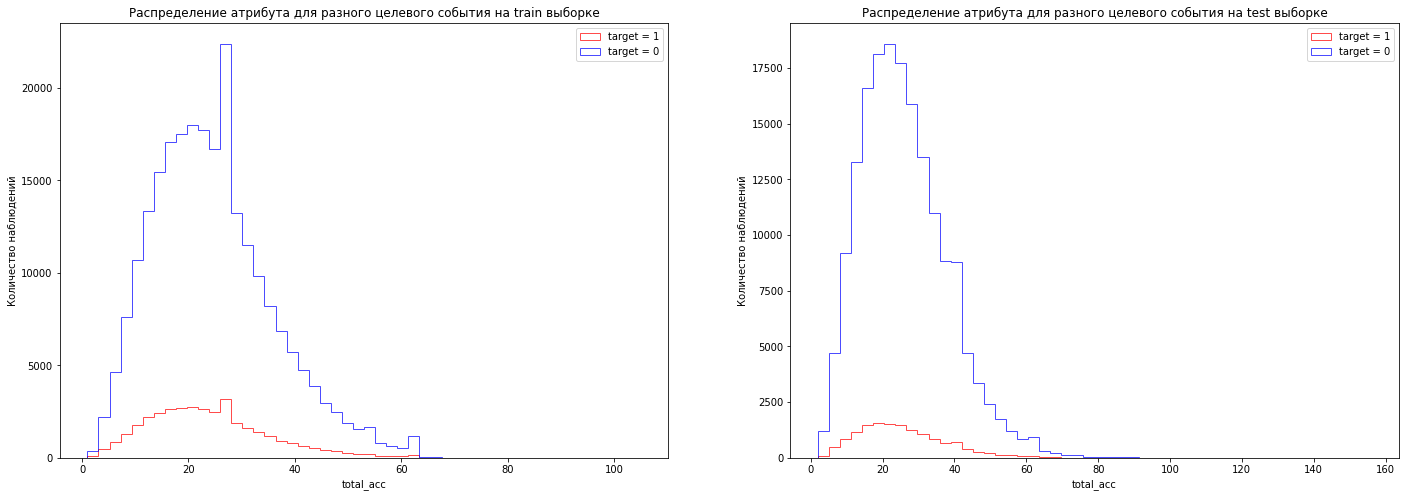


Отображение распределений для атрибута: delinq_2yrs


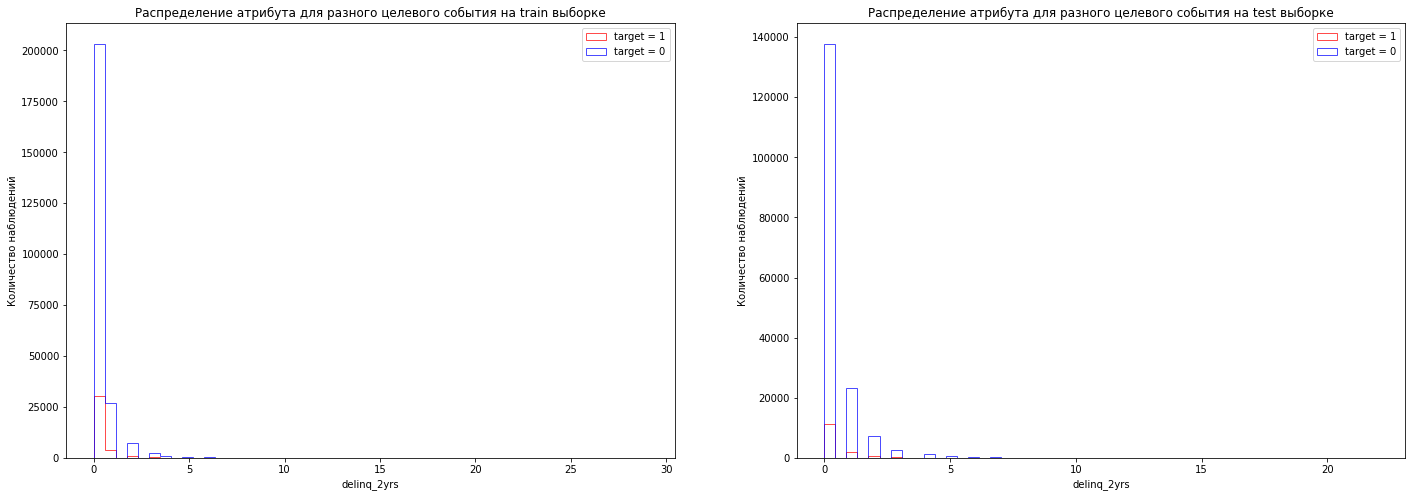


Отображение распределений для атрибута: acc_now_delinq


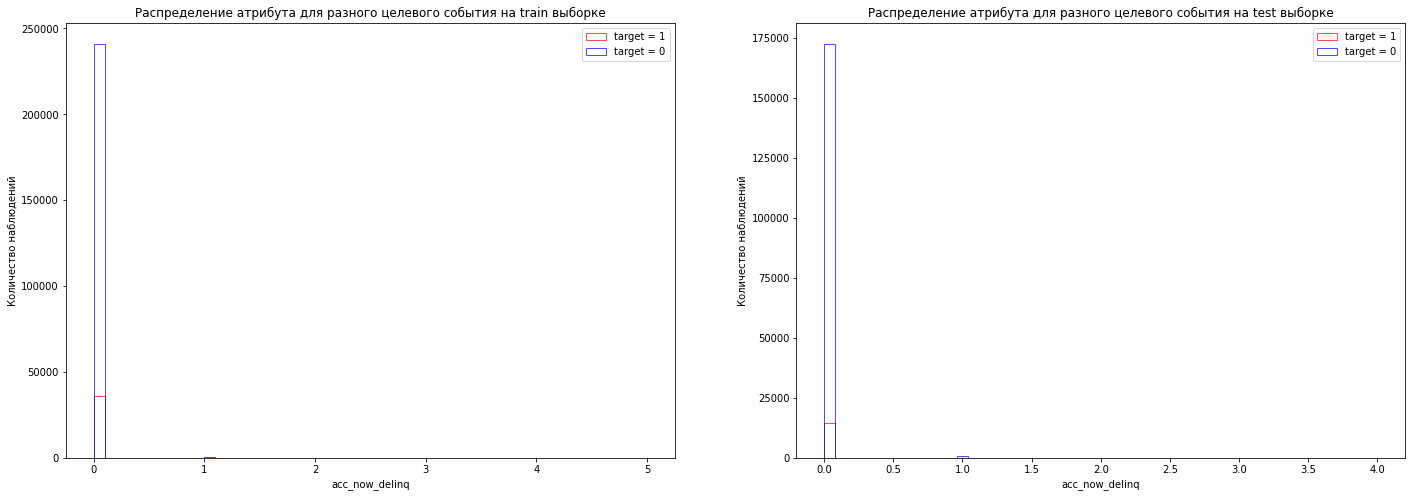


Отображение распределений для атрибута: total_pymnt_inv


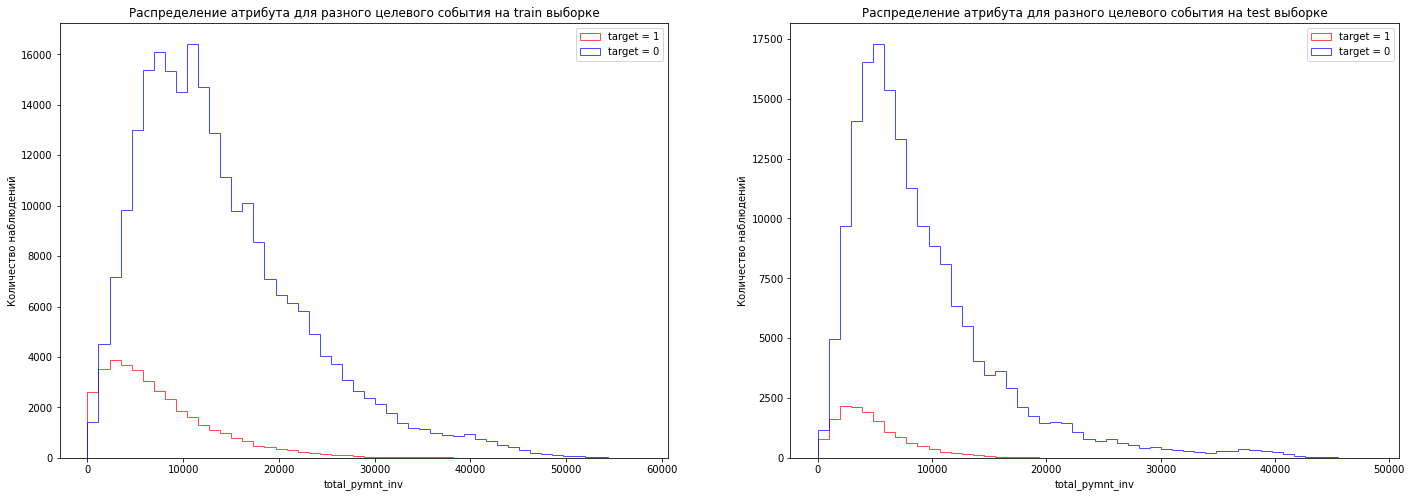


Отображение распределений для атрибута: out_prncp_inv


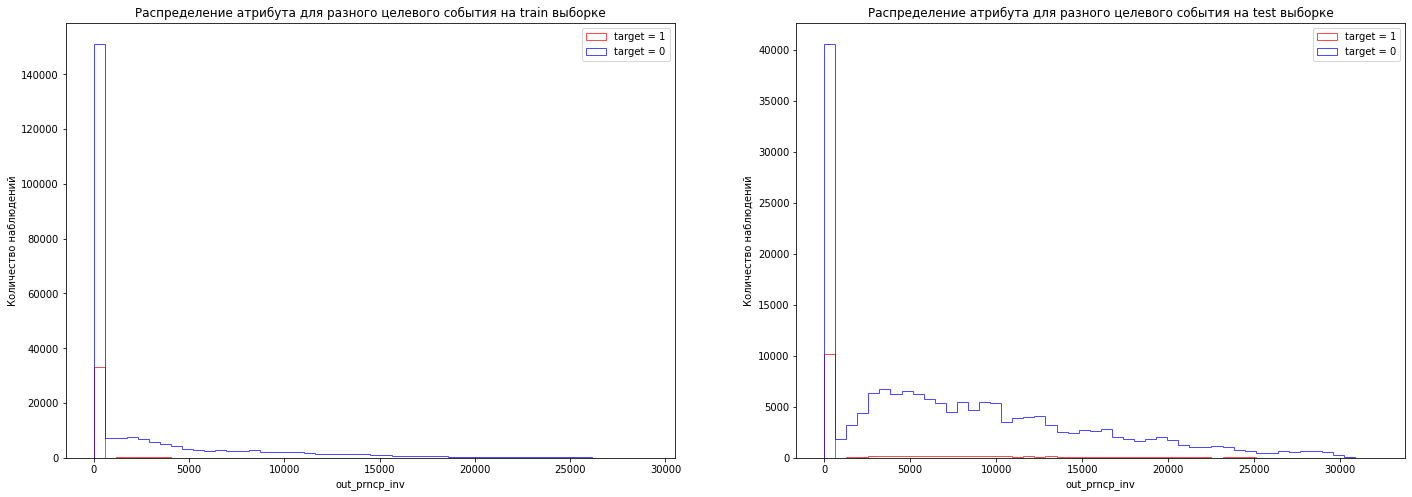


Отображение распределений для атрибута: revol_bal


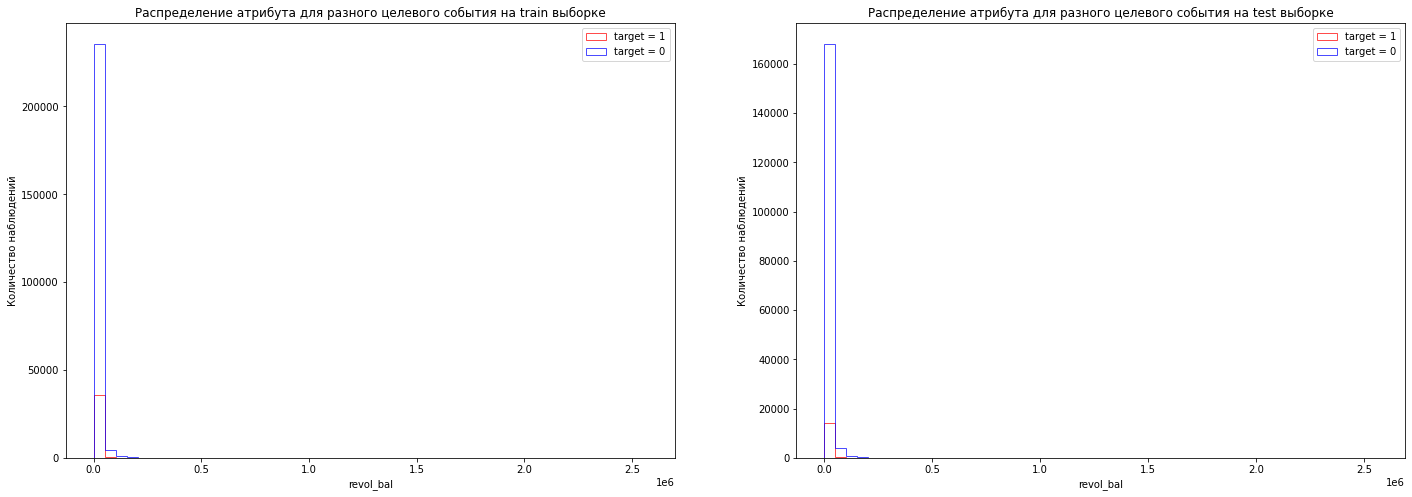


Отображение распределений для атрибута: total_rec_late_fee


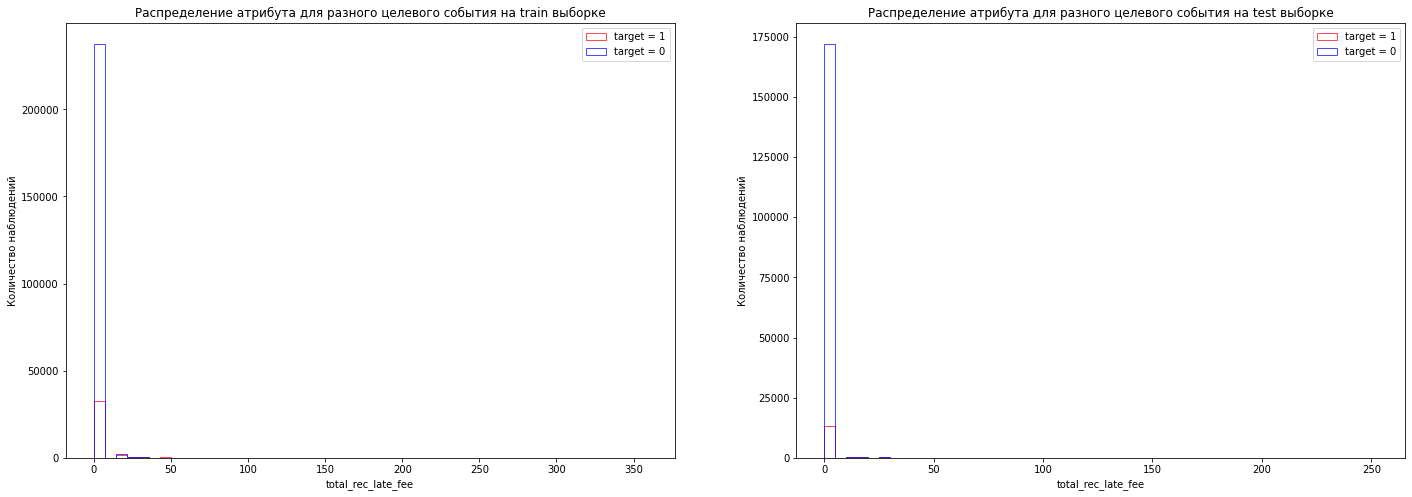


Отображение распределений для атрибута: mths_since_last_delinq


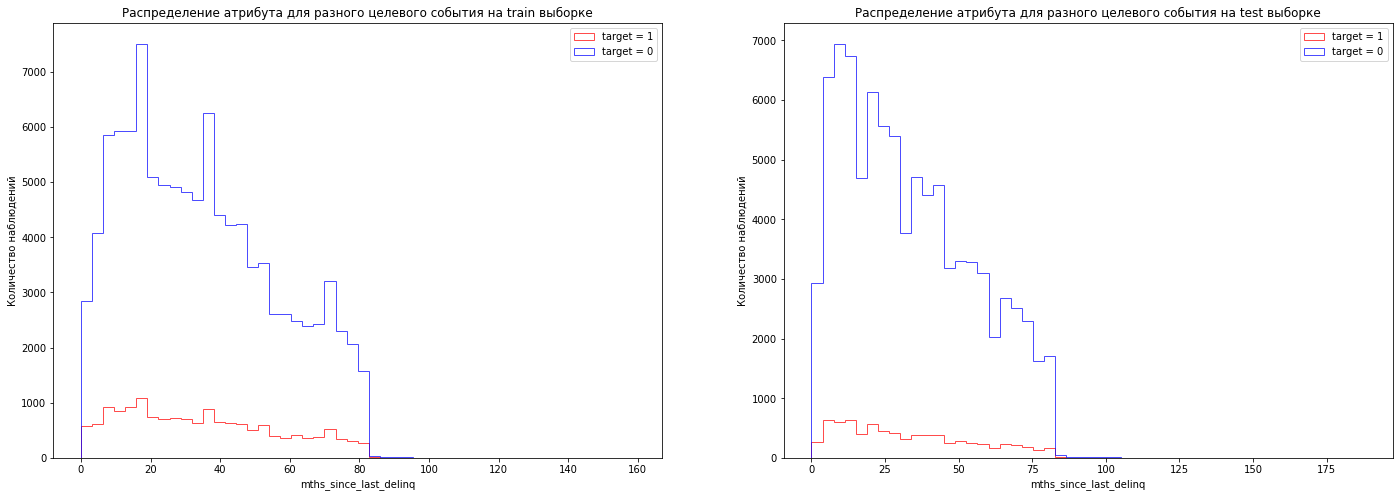


Отображение распределений для атрибута: mths_since_last_record


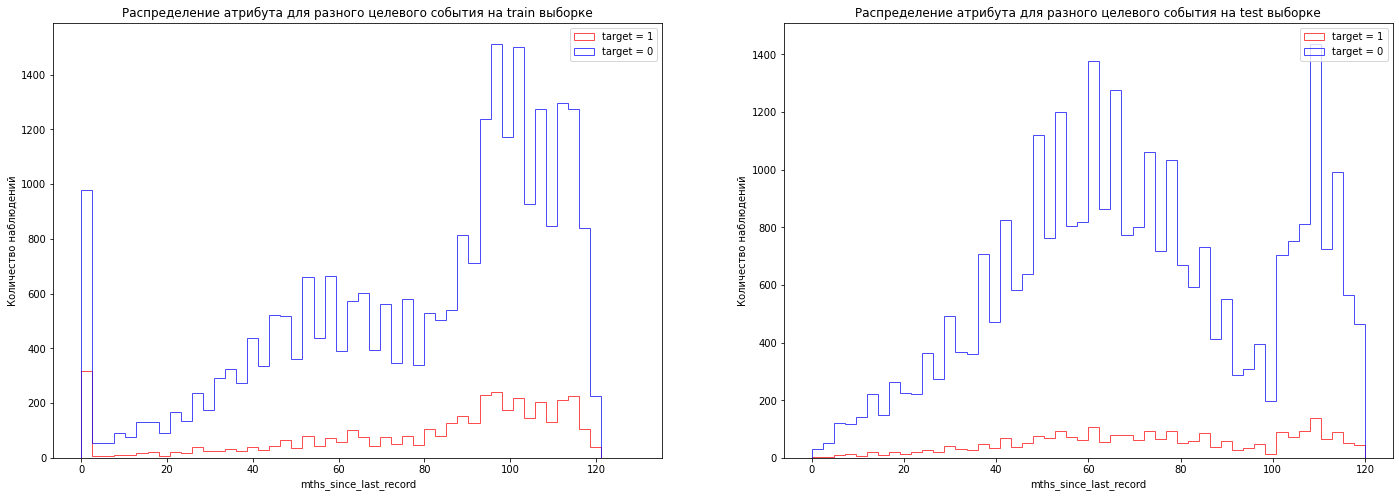


Отображение распределений для атрибута: open_acc


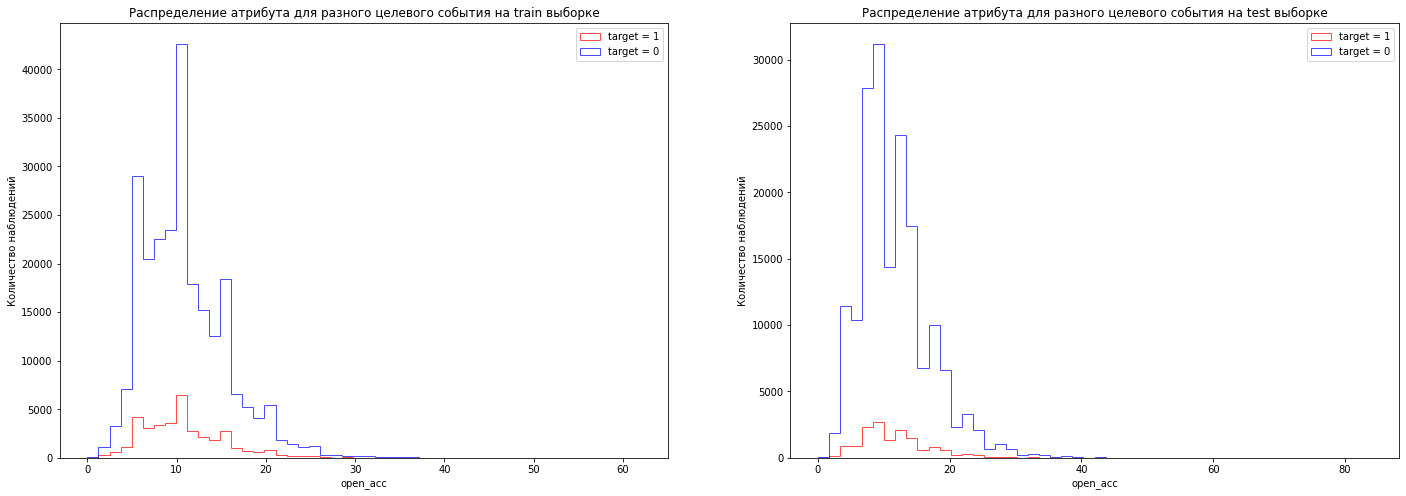


Отображение распределений для атрибута: collections_12_mths_ex_med


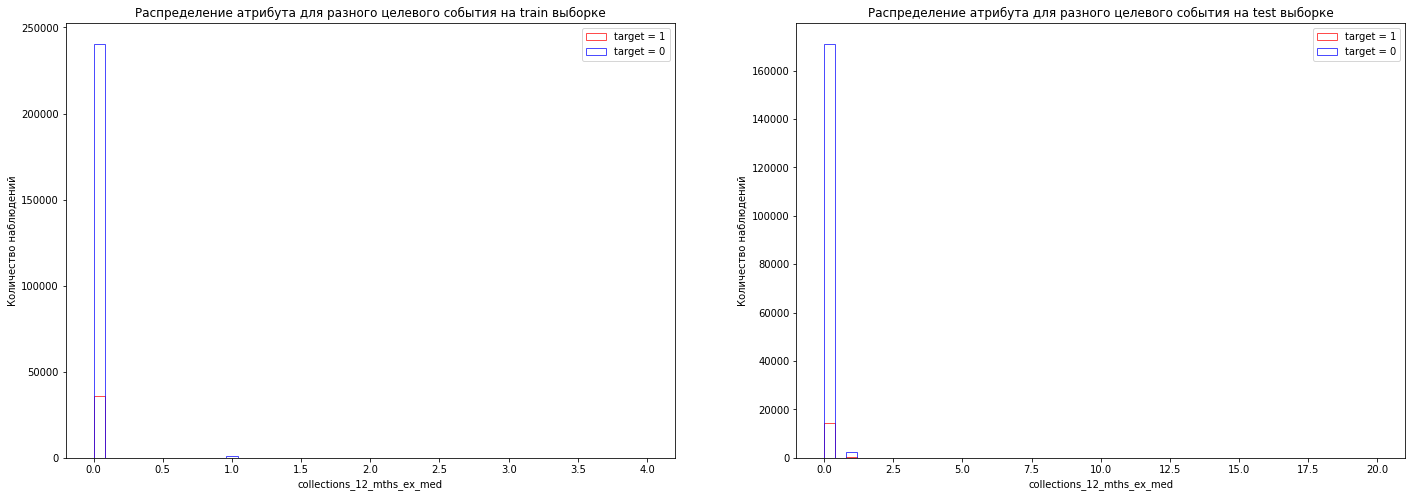


Отображение распределений для атрибута: inq_last_6mths


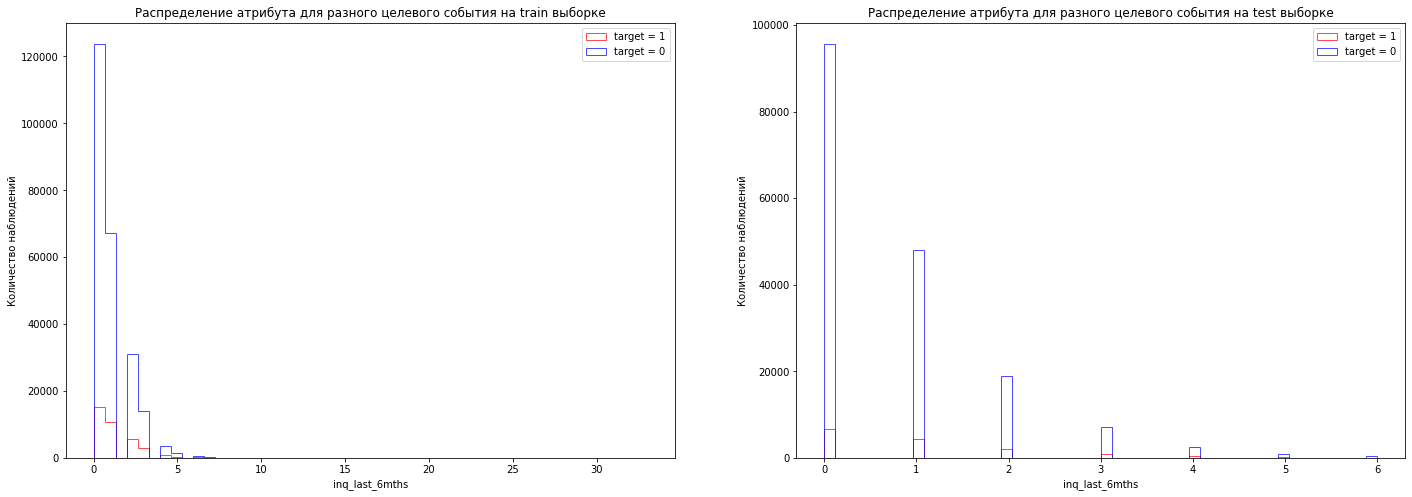


Отображение распределений для атрибута: loan_amnt


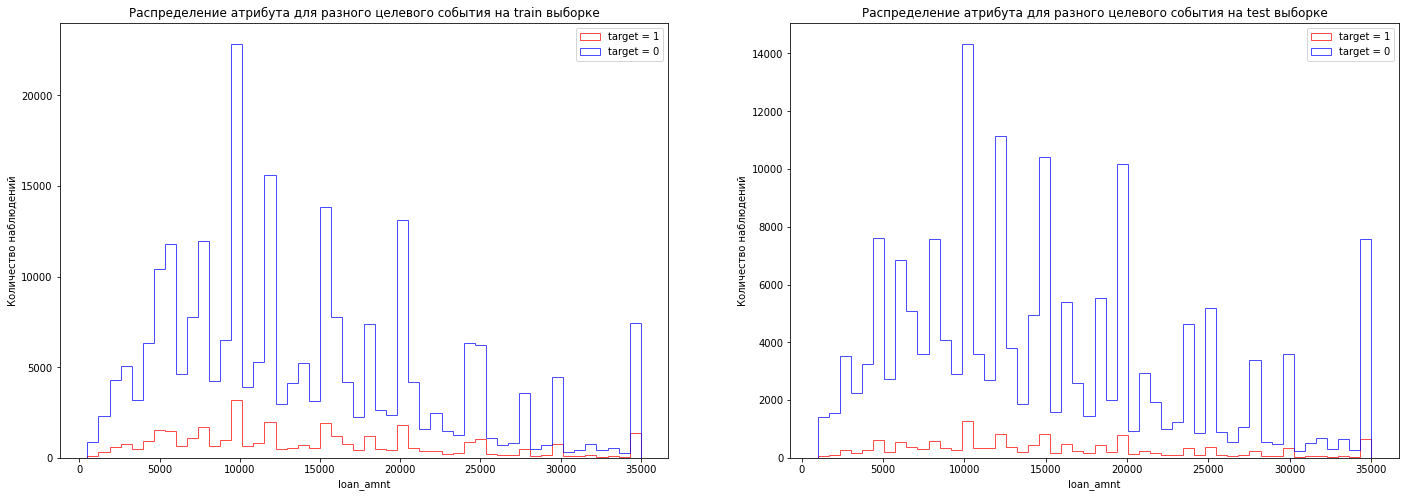


Отображение распределений для атрибута: total_rec_int


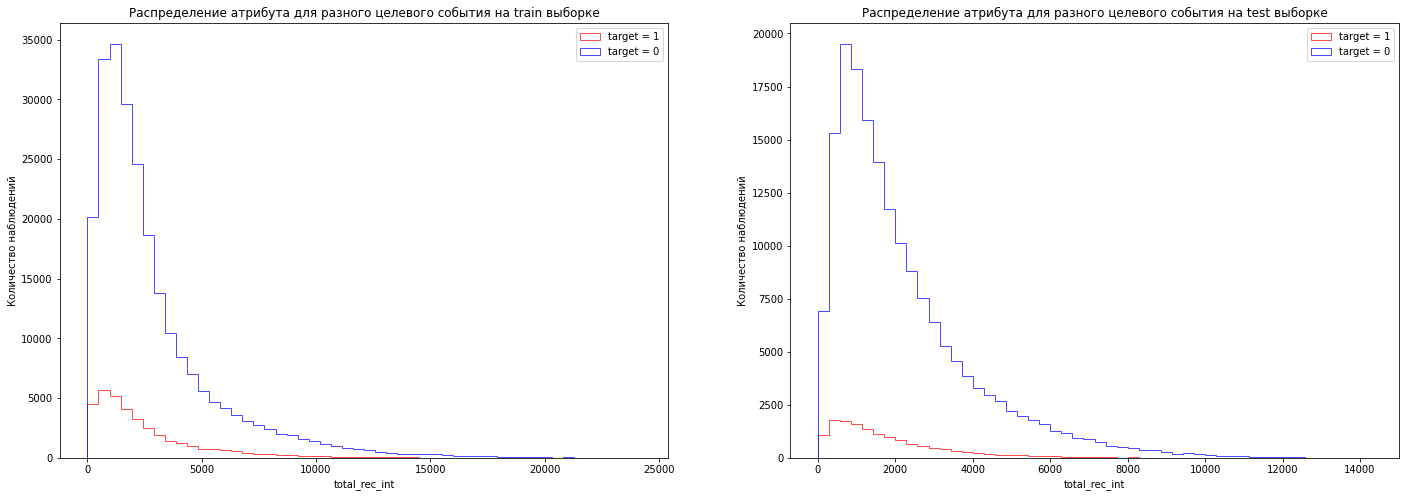


Отображение распределений для атрибута: dti


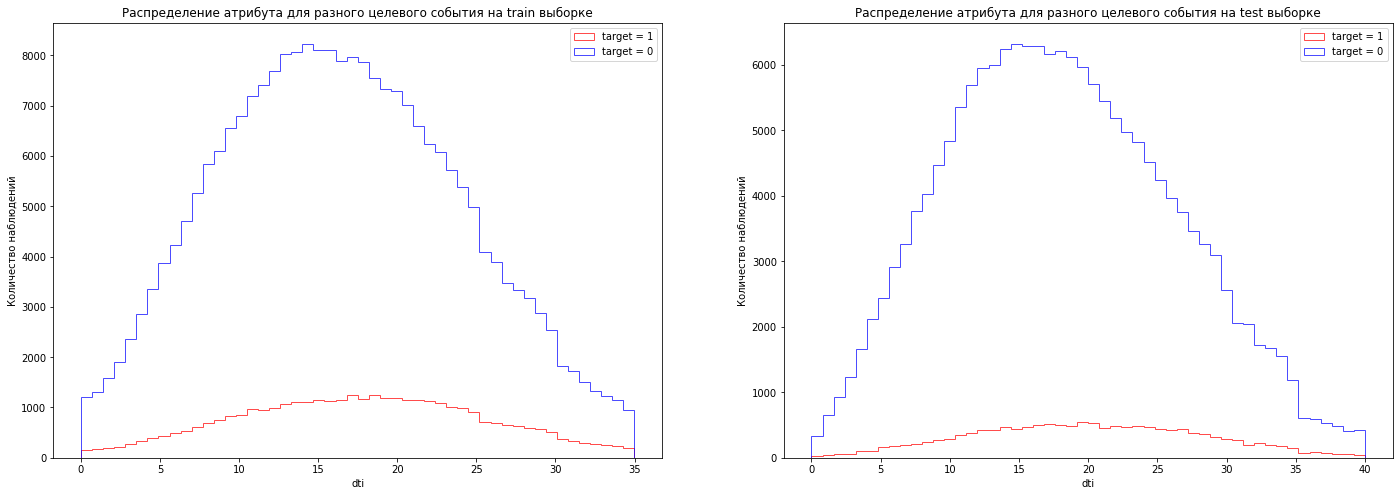


Отображение распределений для атрибута: funded_amnt


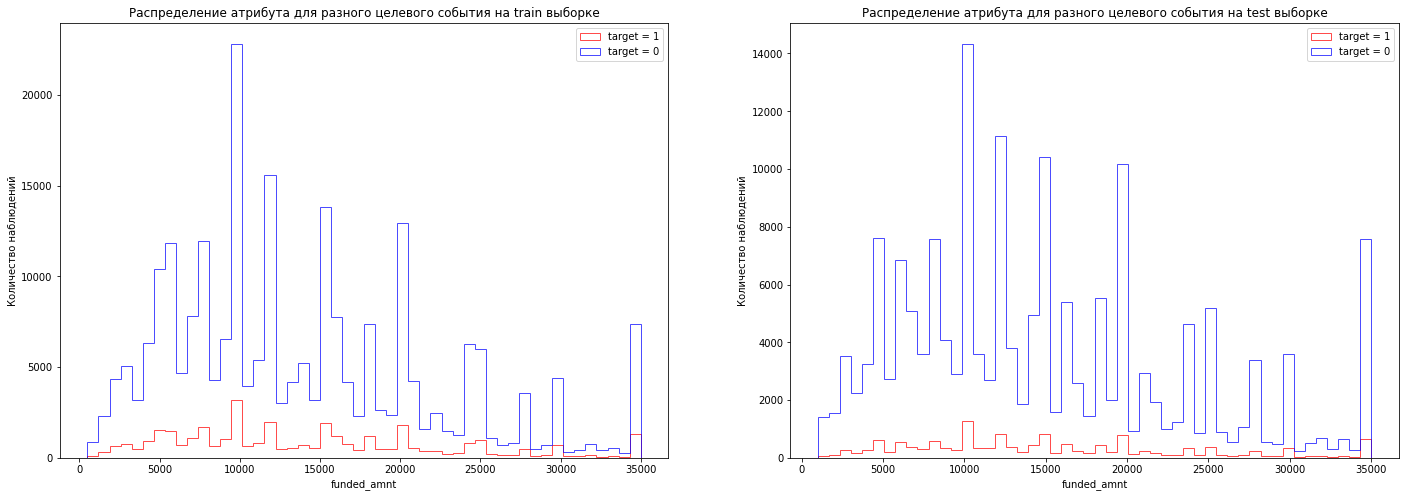


Отображение распределений для атрибута: annual_inc


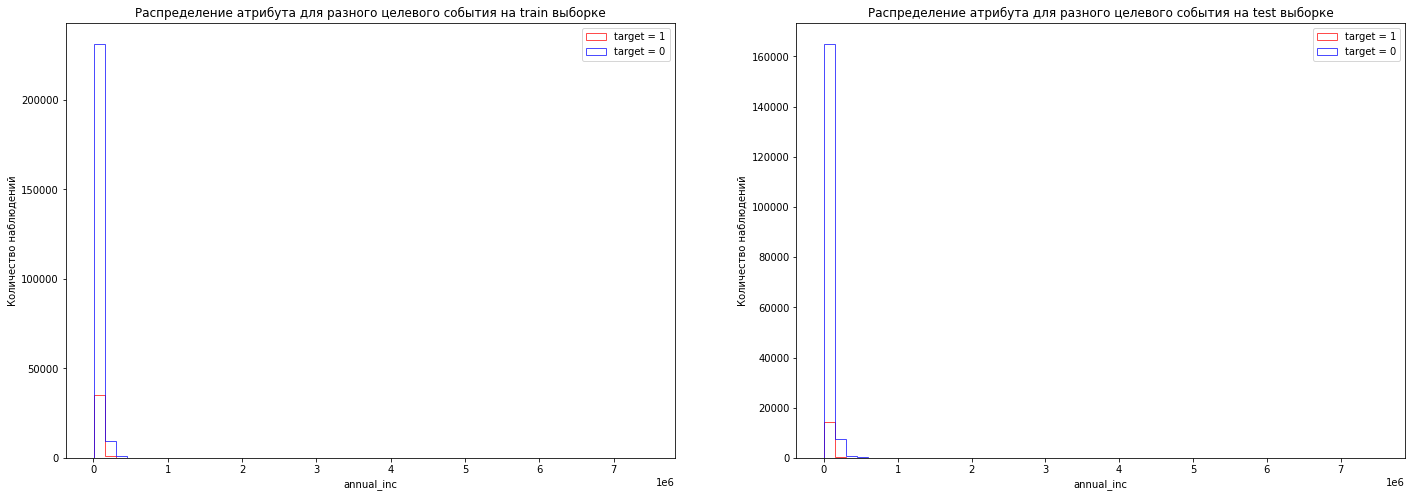


Отображение распределений для атрибута: installment


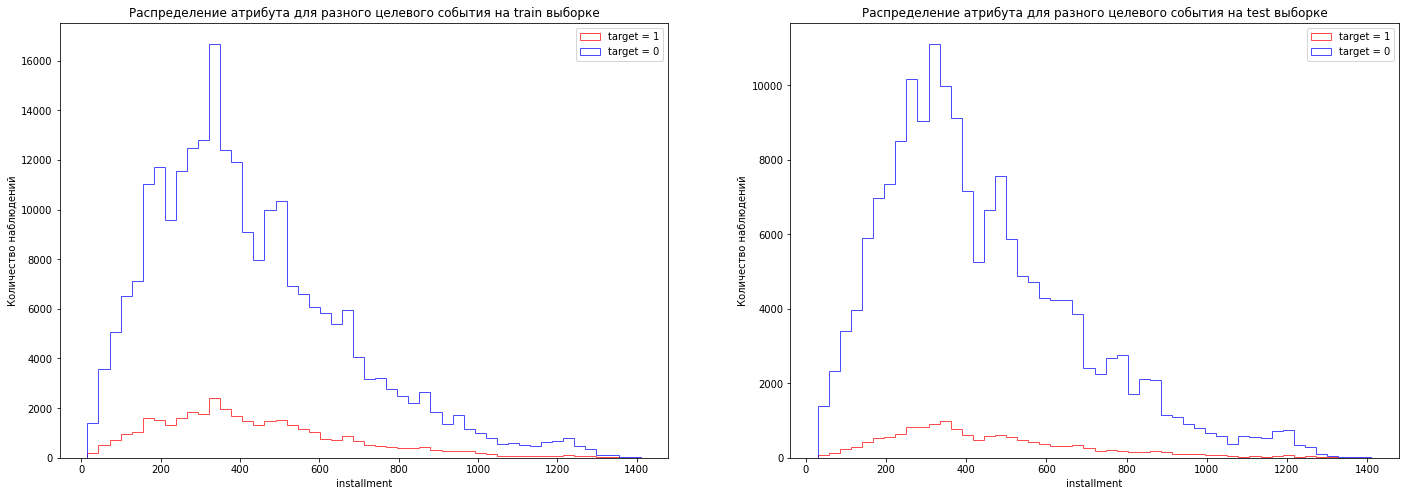


Отображение распределений для атрибута: pub_rec


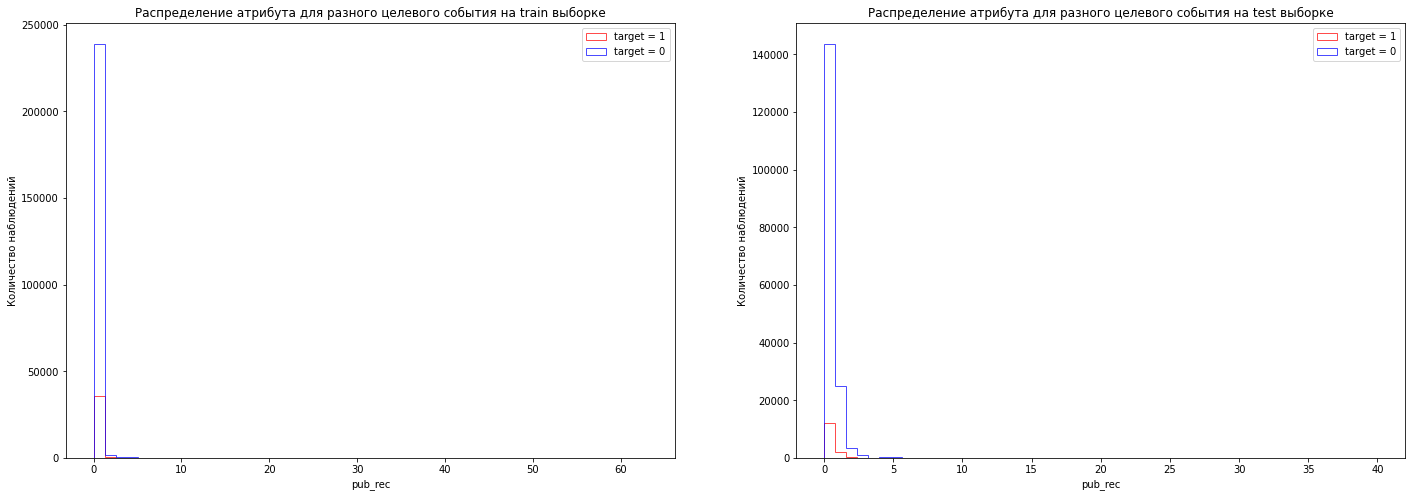


Отображение распределений для атрибута: tot_coll_amt


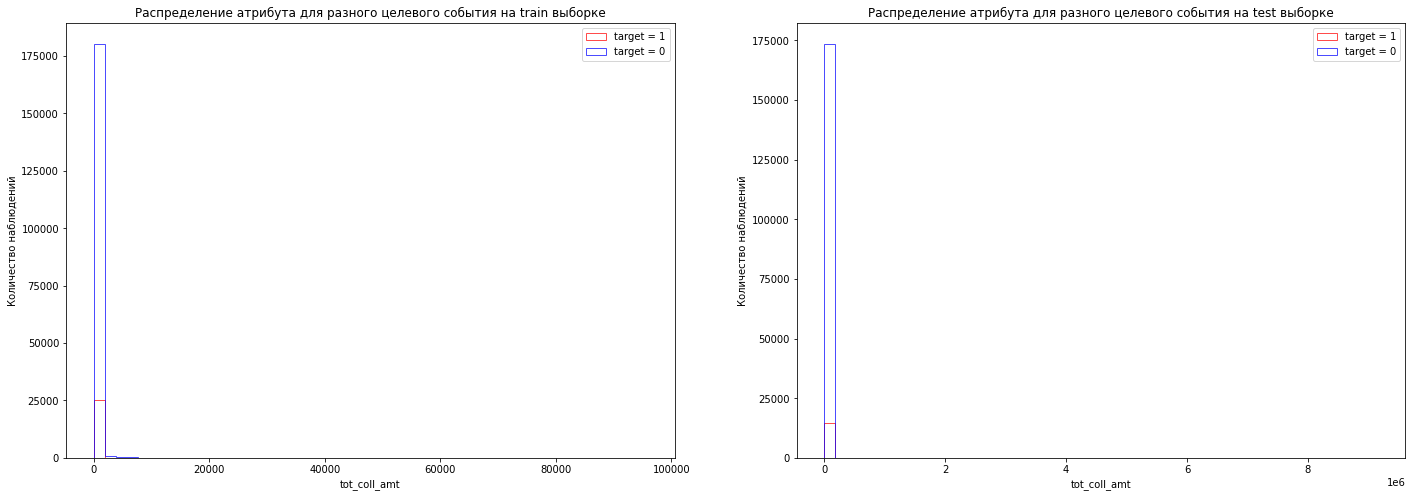


Отображение распределений для атрибута: mths_since_last_major_derog


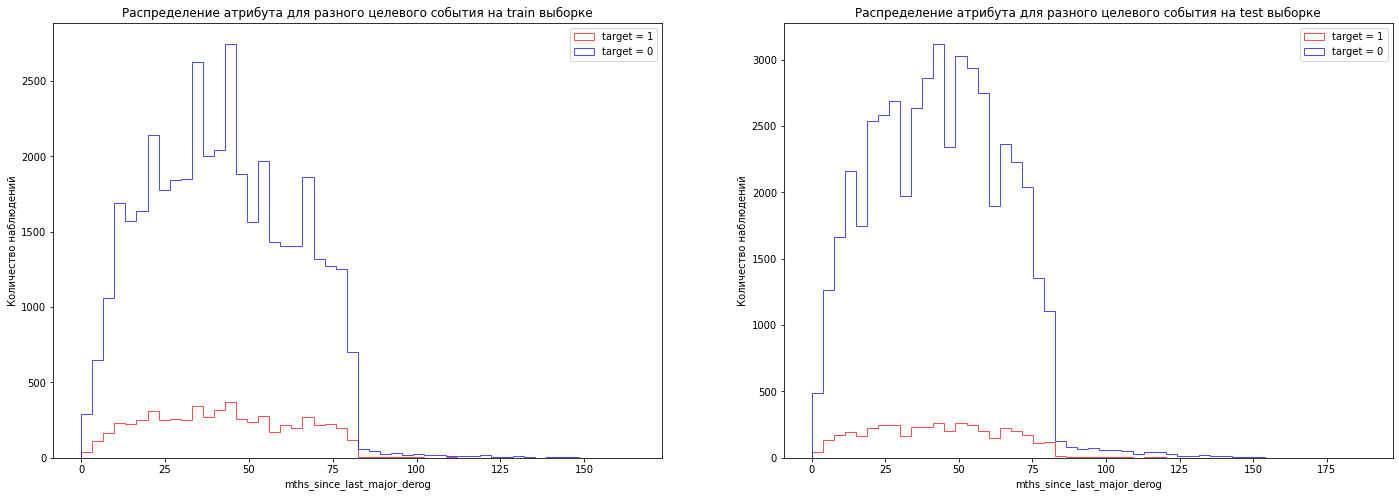


Отображение распределений для атрибута: recoveries


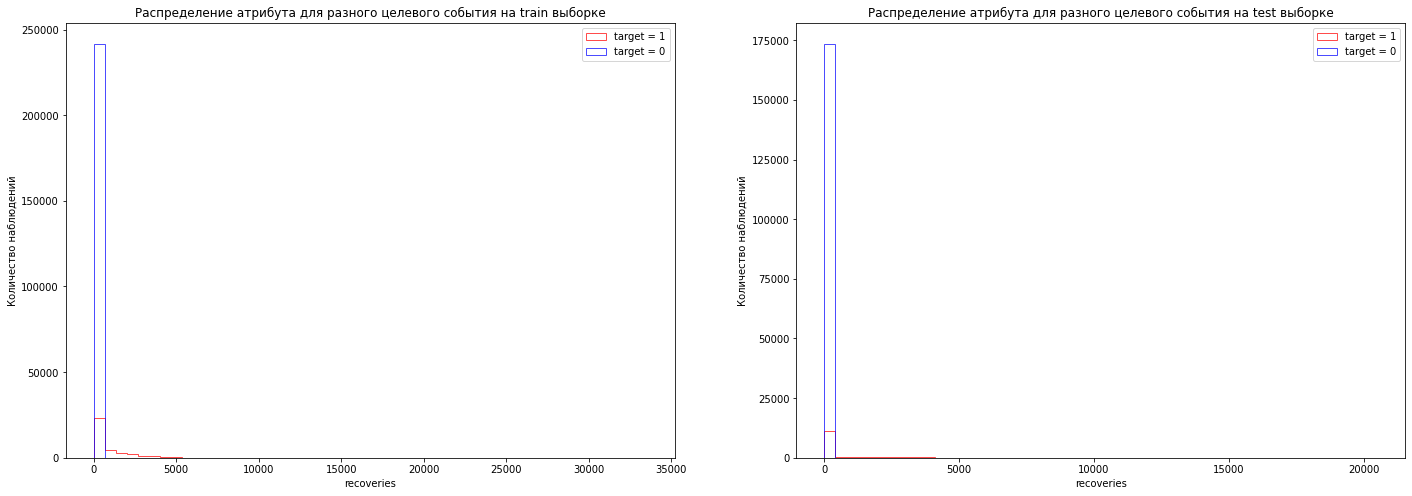


Отображение распределений для атрибута: total_rev_hi_lim


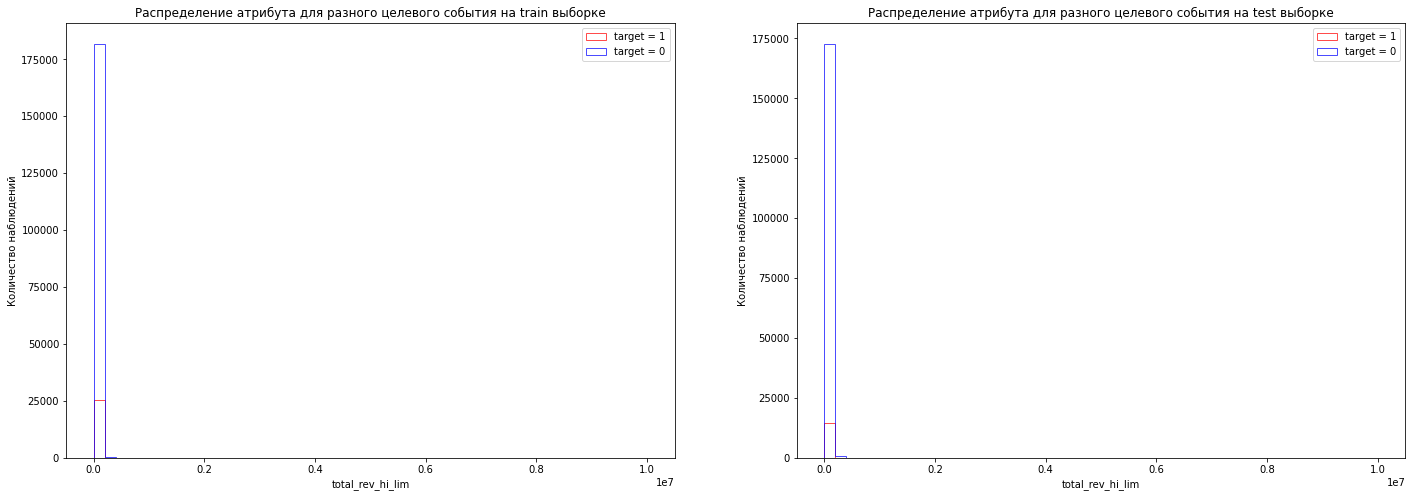


Отображение распределений для атрибута: last_pymnt_amnt


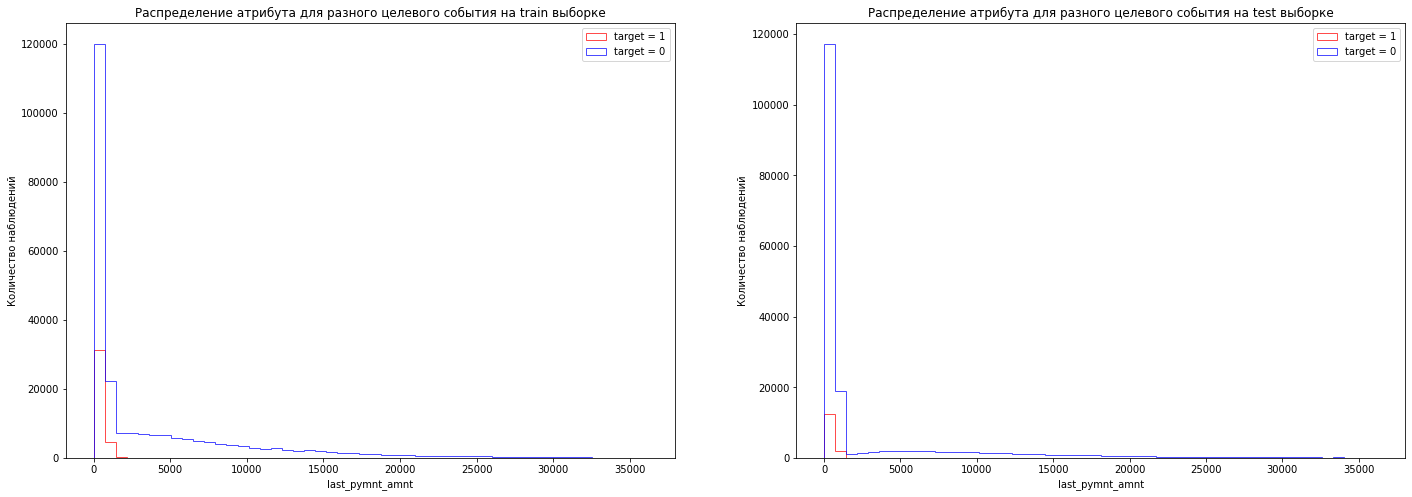


Отображение распределений для атрибута: total_rec_prncp


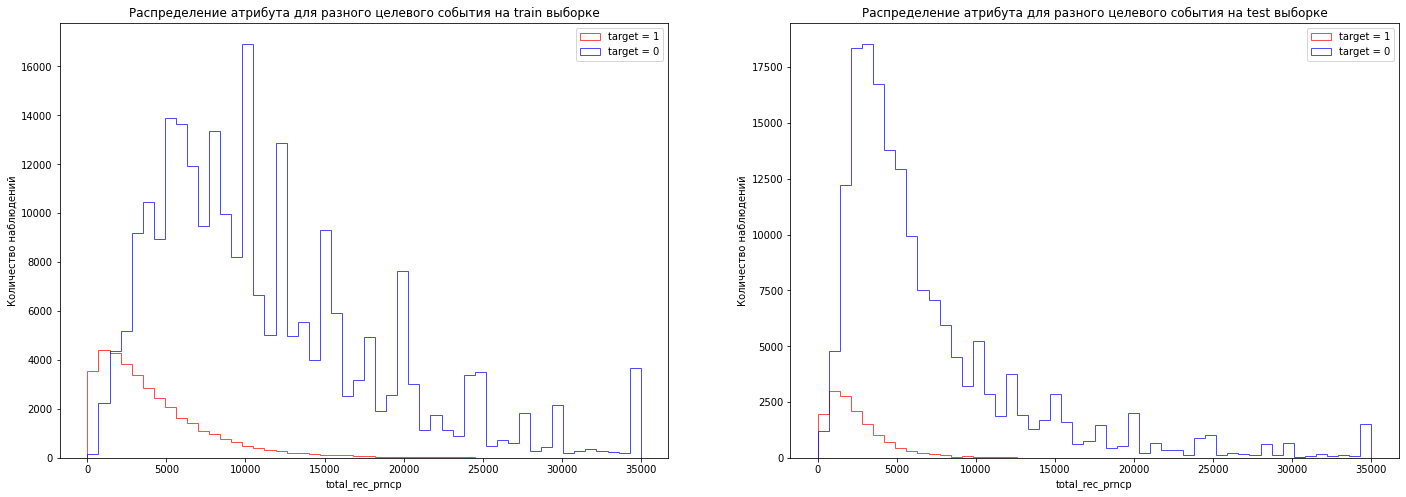


Отображение распределений для атрибута: collection_recovery_fee


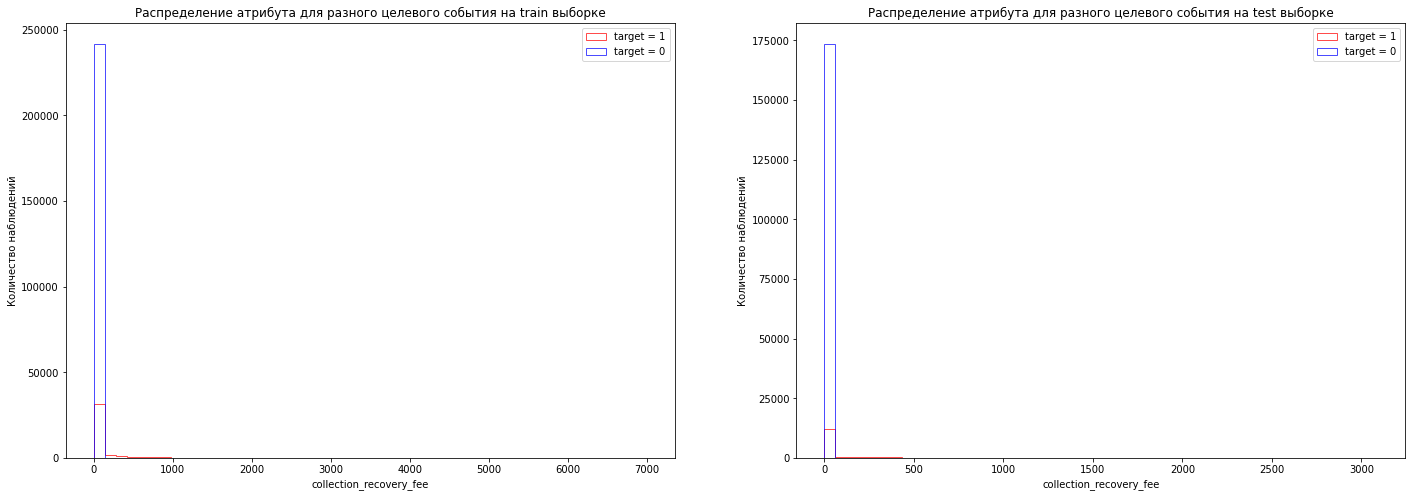


Отображение распределений для атрибута: out_prncp


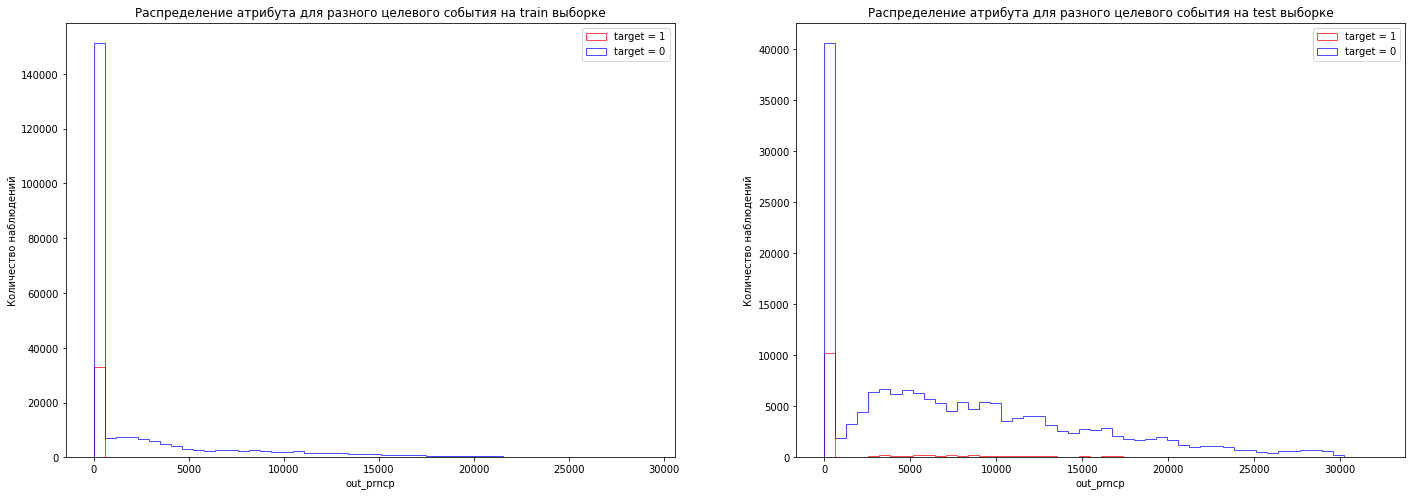


Отображение распределений для атрибута: funded_amnt_inv


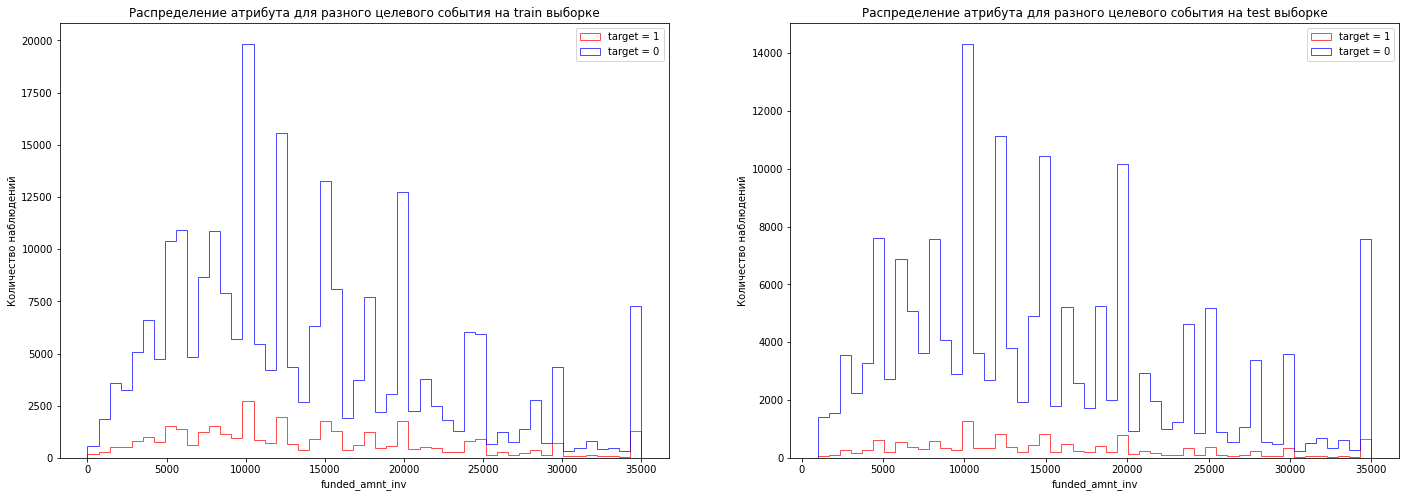


Отображение распределений для атрибута: total_pymnt


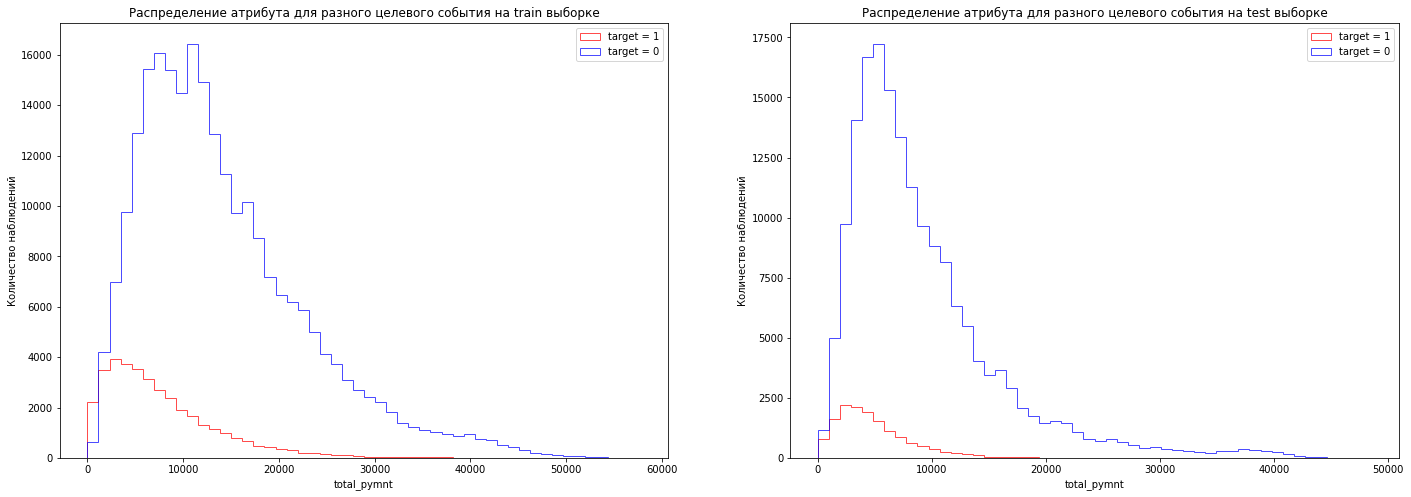


Отображение распределений для атрибута: application_type


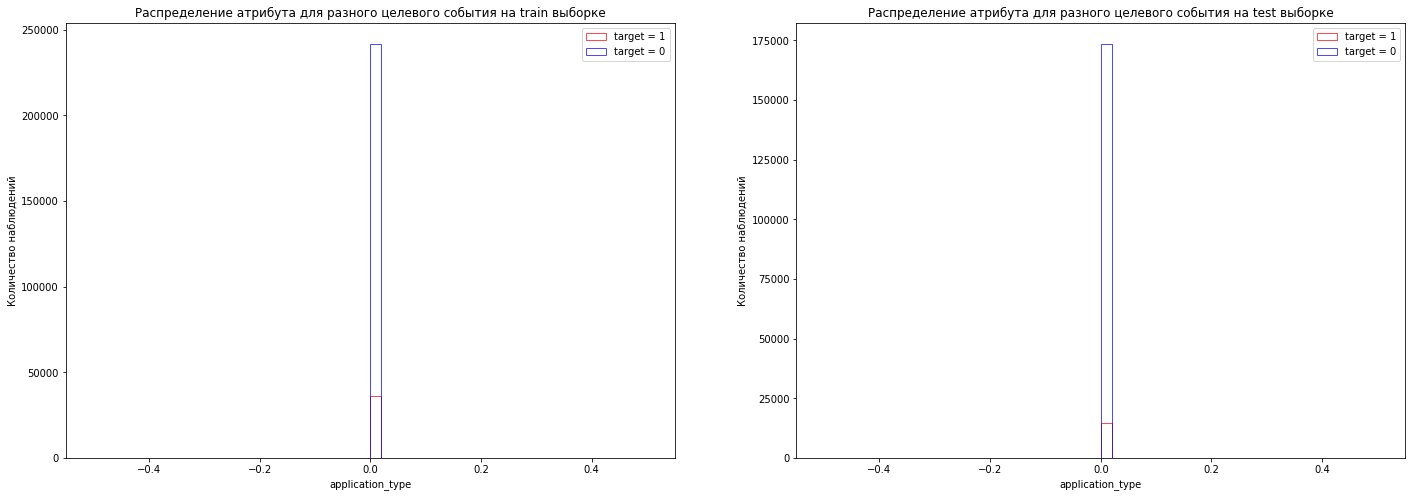


Отображение распределений для атрибута: verification_status


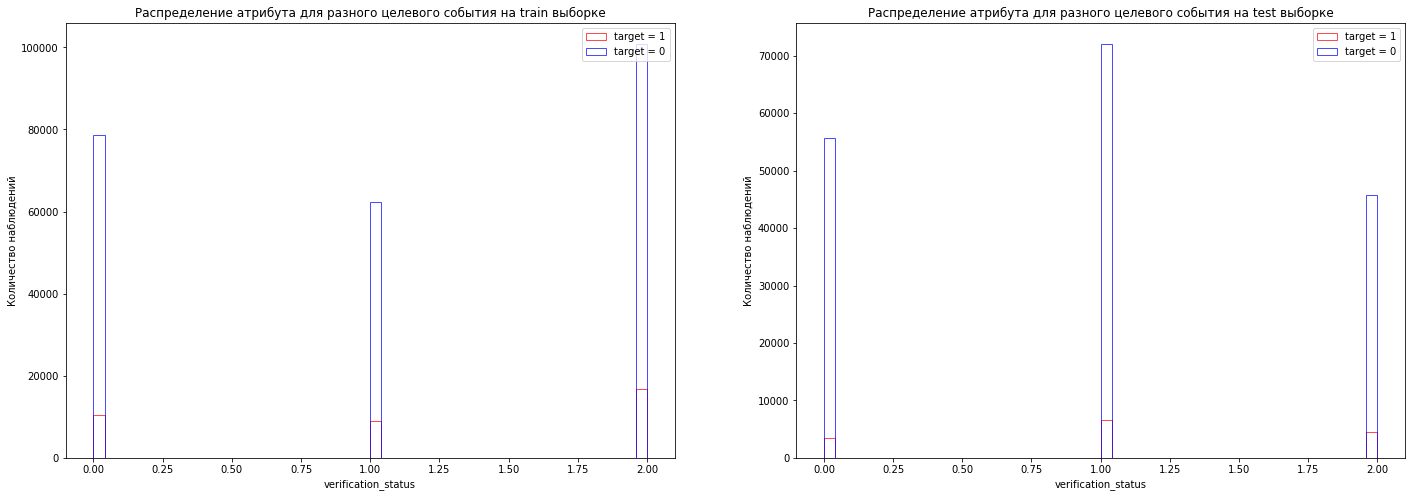


Отображение распределений для атрибута: purpose


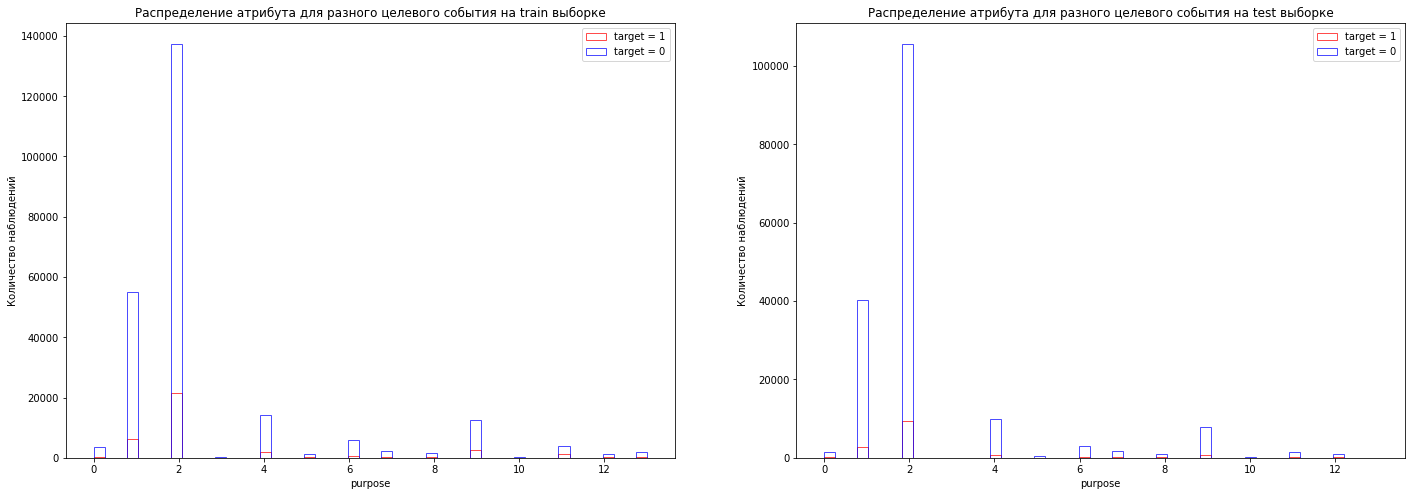


Отображение распределений для атрибута: term


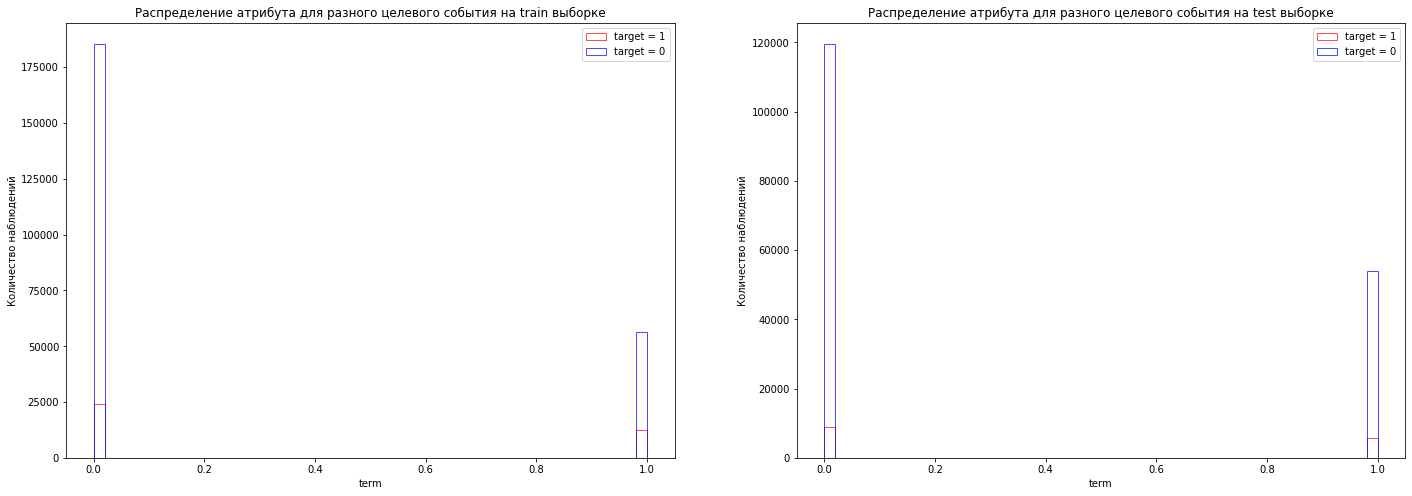


Отображение распределений для атрибута: emp_length


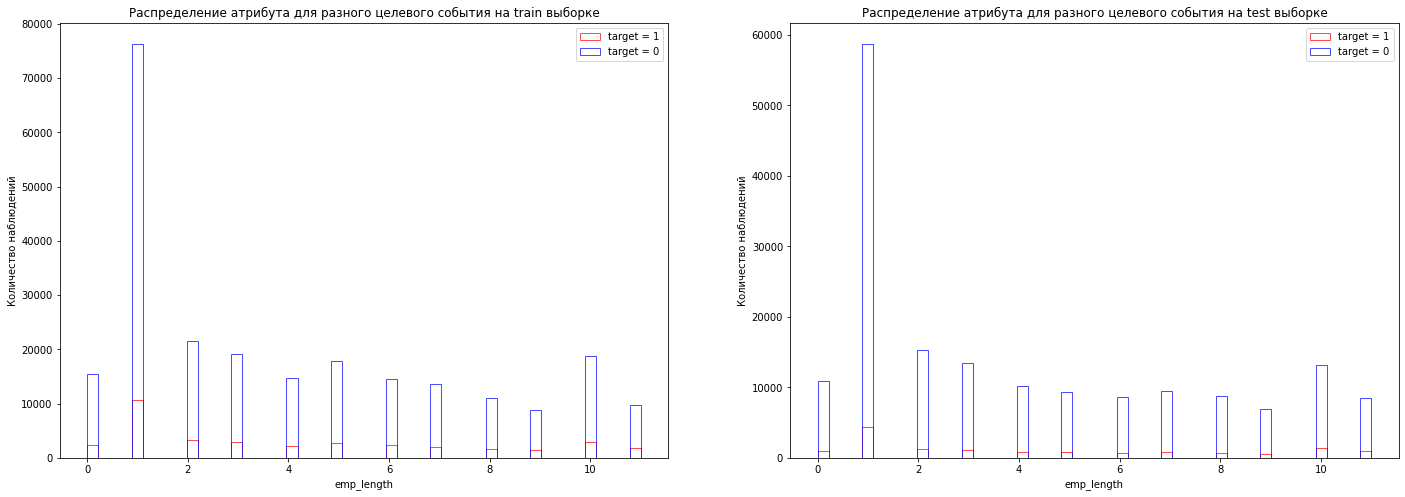


Отображение распределений для атрибута: sub_grade


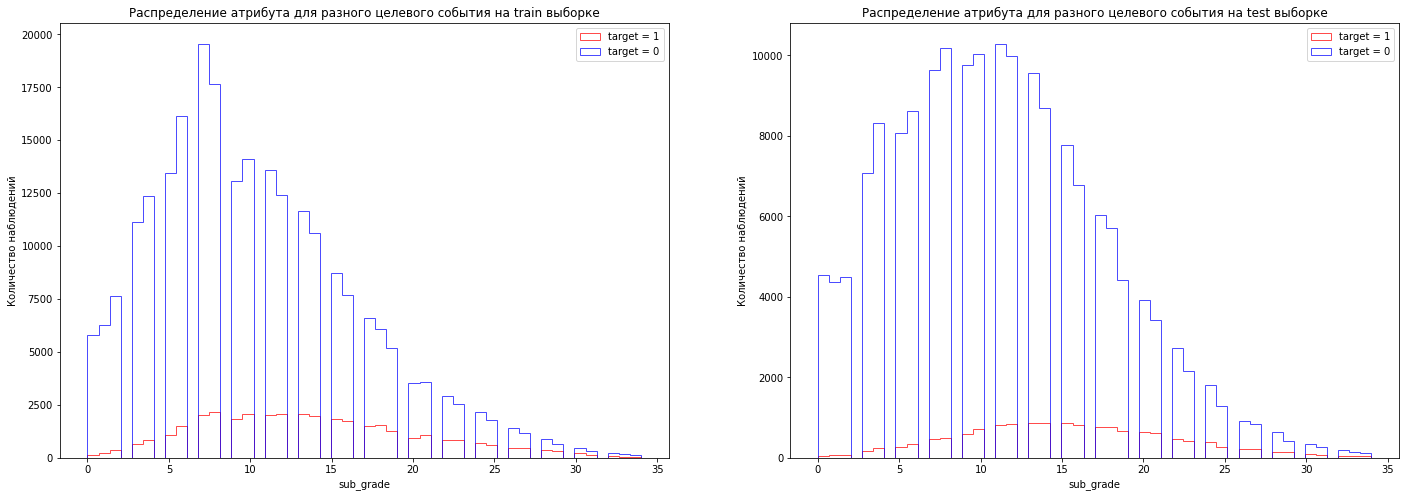


Отображение распределений для атрибута: pymnt_plan


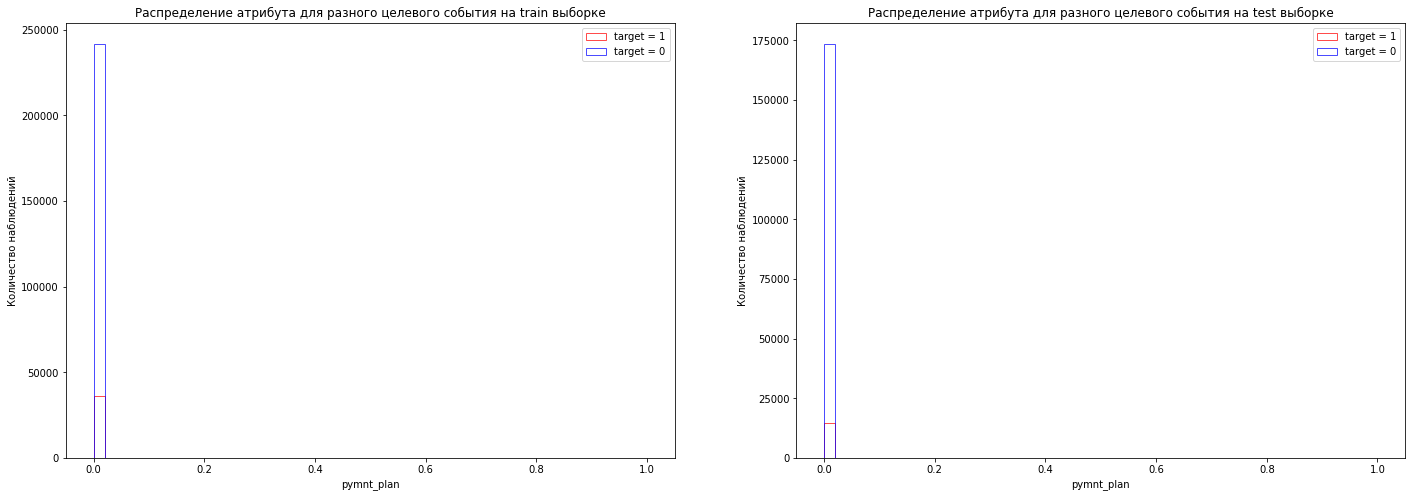


Отображение распределений для атрибута: grade


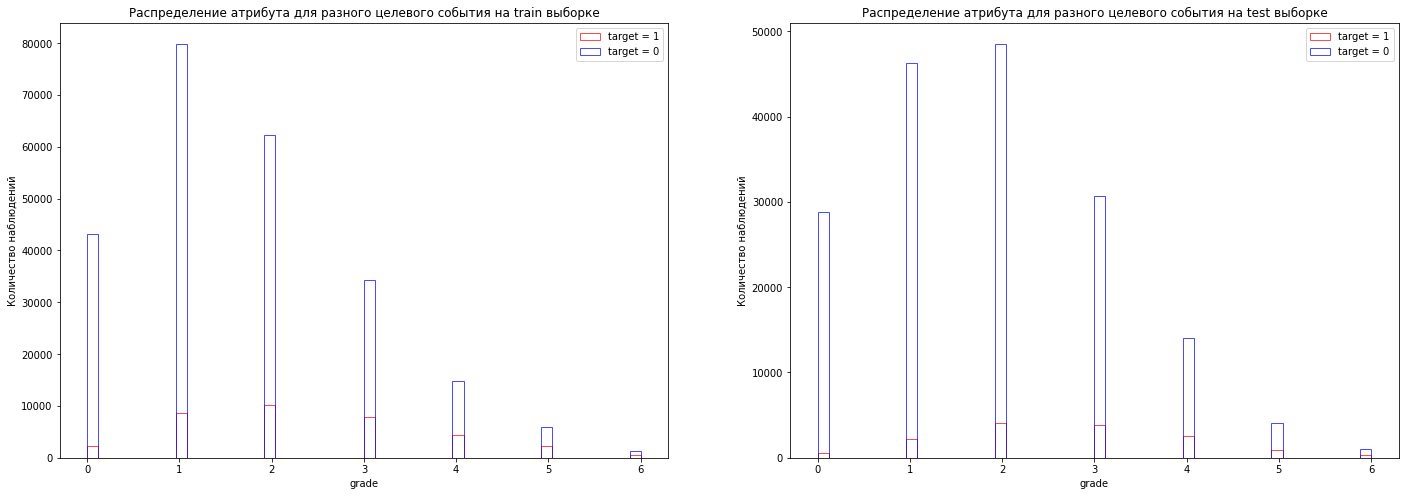


Отображение распределений для атрибута: initial_list_status


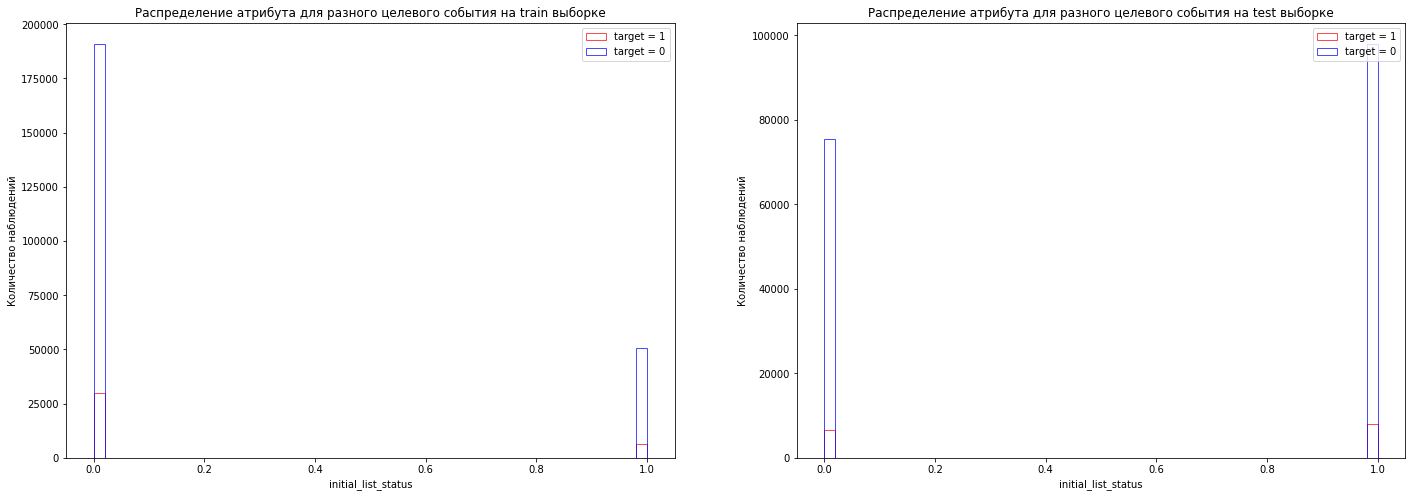


Отображение распределений для атрибута: emp_title


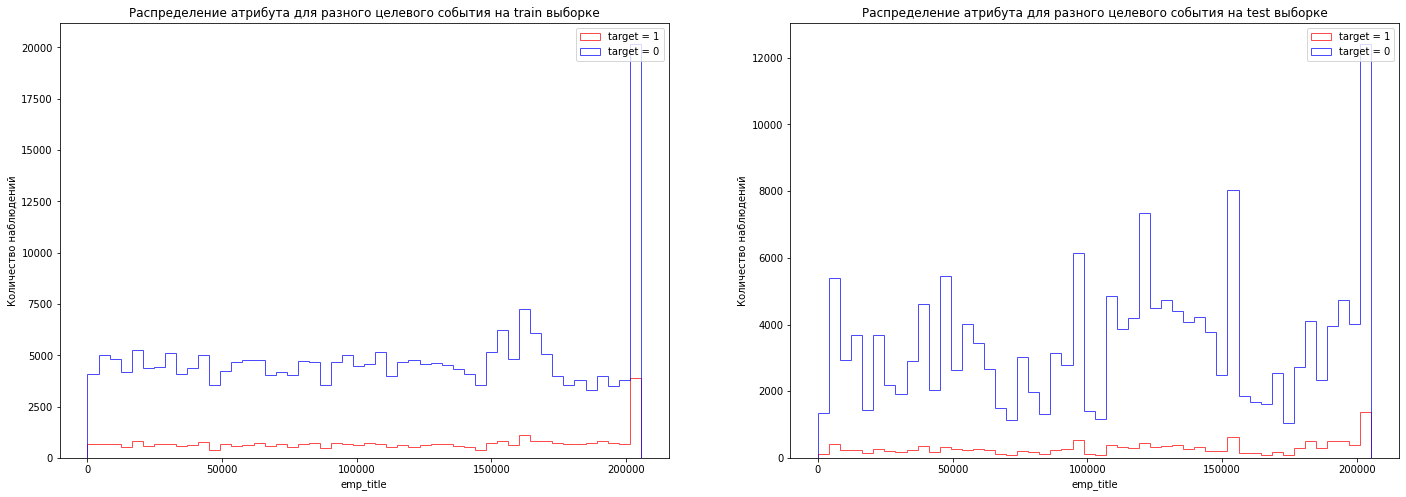


Отображение распределений для атрибута: home_ownership


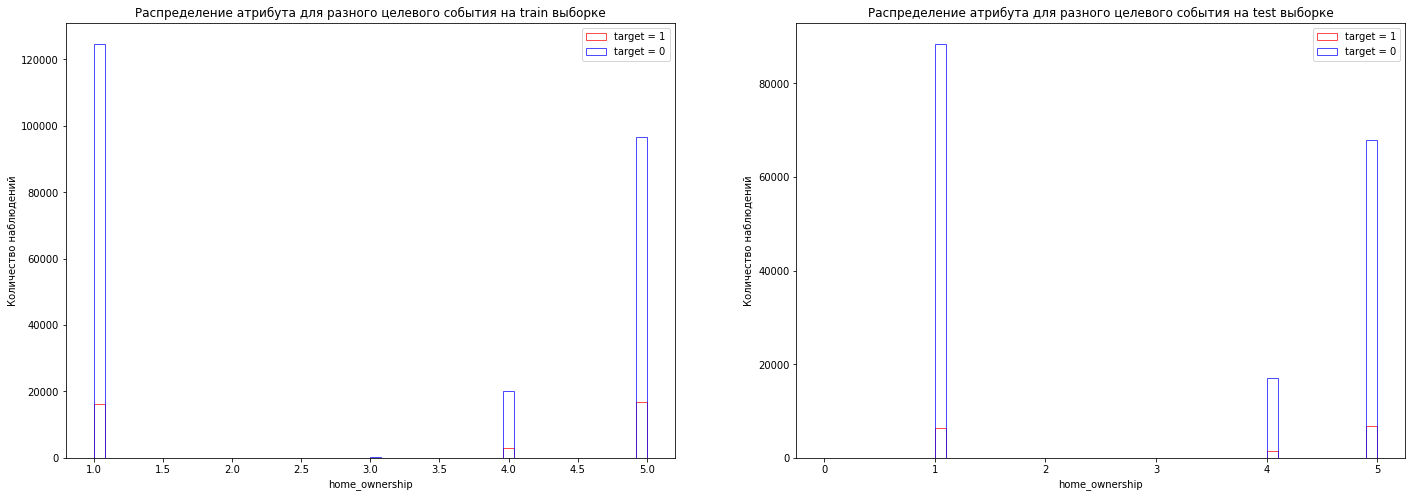


Отображение распределений для атрибута: title


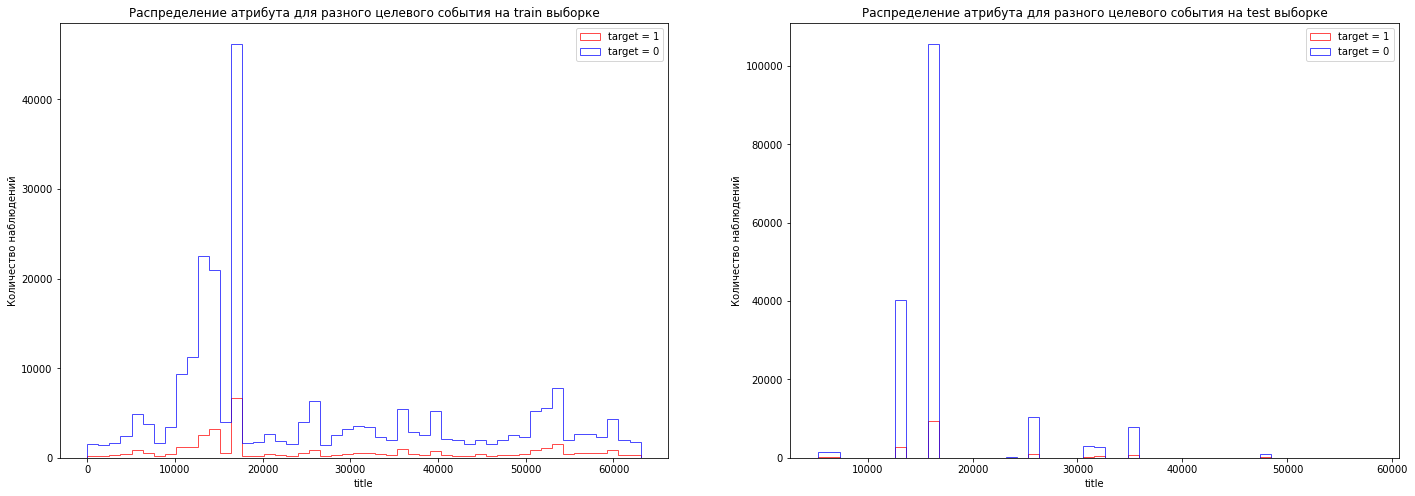

In [76]:
def draw_feature_distribution(data_, interval, category):
    for col in interval + category:
        print(f'Отображение распределений для атрибута: {col}')

        temp_train = data_[data_['test_flg']==0][['target', col]]
        temp_test = data_[data_['test_flg']==1][['target', col]]

        bins = 50

        # Визуализация
        fig = plt.figure(figsize=(24,8))
        ax_1 = fig.add_subplot(1, 2, 1)
        ax_2 = fig.add_subplot(1, 2, 2)

        ax_1.set_title('Распределение атрибута для разного целевого события на train выборке')
        ax_1.hist([temp_train[temp_train['target']==0][col], 
                temp_train[temp_train['target']==1][col]], 
                color=['b','r'],  alpha=0.7, bins=bins, histtype='step', label=['target = 0', 'target = 1'])
        ax_1.set_xlabel(col)
        ax_1.set_ylabel('Количество наблюдений')
        ax_1.legend()

        ax_2.set_title('Распределение атрибута для разного целевого события на test выборке')
        ax_2.hist([temp_test[temp_test['target']==0][col], 
                temp_test[temp_test['target']==1][col]], 
                color=['b','r'],  alpha=0.7, bins=bins, histtype='step', label=['target = 0', 'target = 1'])
        ax_2.set_xlabel(col)
        ax_2.set_ylabel('Количество наблюдений')
        ax_2.legend()

        plt.show()
        print()


draw_feature_distribution(data_ = data_transformed,
                          interval = interrval_features, 
                          category = category_features)

## Поиск аномалий с pyOD, или как рождаются стоп-факторы

Применять поиск аномалий с помощью pyOD будем только на тренировочной выборке, для этого необходимо заполнить пропуски

In [77]:
# Заполнение NaN средним для применения pyOD
# Используем только train выборку
train = data_transformed[data_transformed['test_flg']==0][features].copy()
test = data_transformed[data_transformed['test_flg']==1][features].copy()
for col in train.columns:
    fill_value = train[col].mean()
    train[[col]] = train[[col]].fillna(fill_value)
    test[[col]] = test[[col]].fillna(fill_value)

## Task 3. Поиск аномалий с помощью pyOD

> Реализуйте функцию, которая для каждого наблюдения определит, является ли данное наблюдение выбросом.

> При реализации функции учтите следующее:
* Для поиска аномалий воспользуйтесь библиотекой pyOD, а именно используйте метод pyod.models.pca с долей выбросов равной 0.01 и random_state=42

> Описание функции:
* На вход принимает:
1. Train выборку с атрибутами
1. Test выборку с атрибутами
* Возвращает список лейблов для каждого наблюдения: 1- если наблюдение является выбросом и 0 - если наблюдение не является выбросом

In [78]:
def find_outliers(data_tr, data_ts):
    # YOU CODE HERE
    pca = pyod_PCA(contamination=0.01, random_state=42)
    pca.fit(data_tr)
    train_labels = pca.predict(data_tr)
    test_labels = pca.predict(data_ts)
    return train_labels, test_labels

In [79]:
# Проверяем реализацию функции
assert_outliers_labels_train, assert_outliers_labels_test = find_outliers(data_tr = assert_data_transformed[assert_data_transformed['test_flg']==0][assert_interrval_features + assert_category_features],
                                                                          data_ts = assert_data_transformed[assert_data_transformed['test_flg']==1][assert_interrval_features + assert_category_features],
                                                                          )

assert assert_outliers_labels_train.shape == (313,)
assert assert_outliers_labels_test.shape == (287,)
assert sum(assert_outliers_labels_train) + sum(assert_outliers_labels_test) == 6
assert sum(assert_outliers_labels_train[1000:2500]) == 0
assert sum(assert_outliers_labels_test[2000:4000]) == 0

In [80]:
# Применяем функцию к целевой таблице
outliers_labels_train, outliers_labels_test = find_outliers(data_tr = train,
                                                            data_ts = test,
                                                            )

Воспользуемся методом понижения размерности, чтобы отобразить на плоскости выбросы

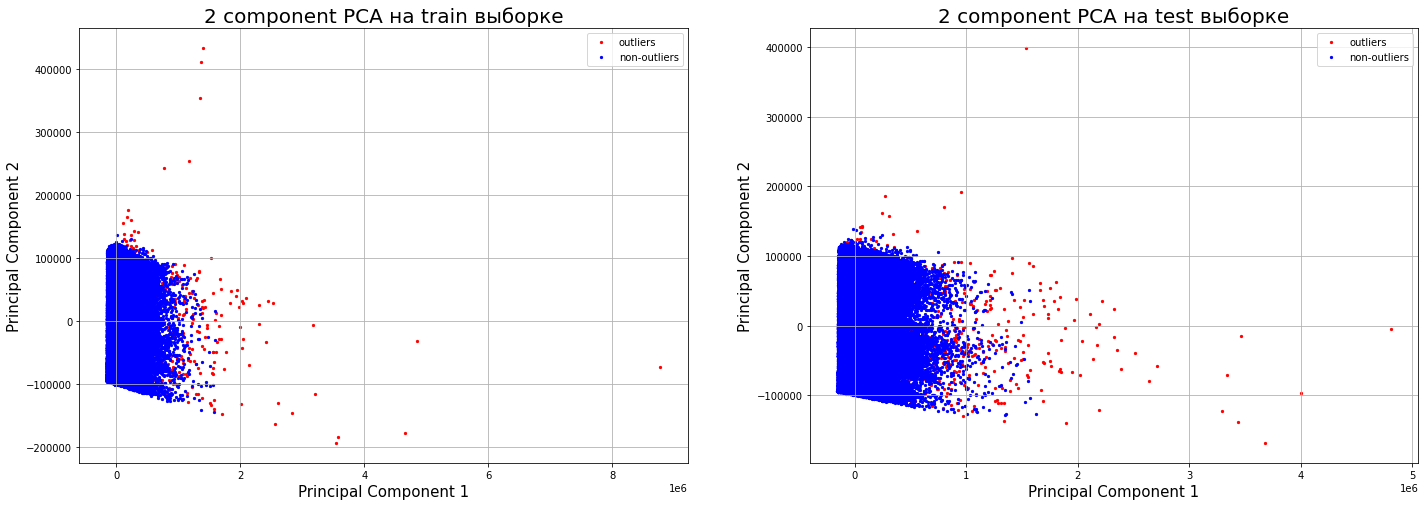

In [81]:
# Применения PCA для визуализации
pca = sklearn.decomposition.PCA(n_components=2)
principalComponents_train = pca.fit_transform(train)
principalComponents_test = pca.transform(test)
principalDf_train = pd.DataFrame(data = principalComponents_train, 
                                 columns = ['principal component 1', 'principal component 2']
                                 )
principalDf_test = pd.DataFrame(data = principalComponents_test, 
                                columns = ['principal component 1', 'principal component 2']
                                )

# Визуализация
fig = plt.figure(figsize = (24,8))
ax_1 = fig.add_subplot(1,2,1) 
ax_2 = fig.add_subplot(1,2,2) 

ax_1.set_xlabel('Principal Component 1', fontsize = 15)
ax_1.set_ylabel('Principal Component 2', fontsize = 15)
ax_1.set_title('2 component PCA на train выборке', fontsize = 20)
ax_1.scatter(principalDf_train.loc[(outliers_labels_train == 1), 'principal component 1'],
             principalDf_train.loc[(outliers_labels_train == 1), 'principal component 2'],
             c = 'r',
             s = 5)
ax_1.scatter(principalDf_train.loc[(outliers_labels_train == 0), 'principal component 1'],
             principalDf_train.loc[(outliers_labels_train == 0), 'principal component 2'],
             c = 'b',
             s = 5)
ax_1.legend(['outliers', 'non-outliers'])
ax_1.grid()

ax_2.set_xlabel('Principal Component 1', fontsize = 15)
ax_2.set_ylabel('Principal Component 2', fontsize = 15)
ax_2.set_title('2 component PCA на test выборке', fontsize = 20)
ax_2.scatter(principalDf_test.loc[(outliers_labels_test == 1), 'principal component 1'],
             principalDf_test.loc[(outliers_labels_test == 1), 'principal component 2'],
             c = 'r',
             s = 5)
ax_2.scatter(principalDf_test.loc[(outliers_labels_test == 0), 'principal component 1'],
             principalDf_test.loc[(outliers_labels_test == 0), 'principal component 2'],
             c = 'b',
             s = 5)
ax_2.legend(['outliers', 'non-outliers'])
ax_2.grid()

In [82]:
# Сравним среднее значение атрибутов в сегменте выбросов и основном сегменте
# Выводим топ-20 атрибутов с самым большим различием в средних

temp = {'col' : [],
        'avg_value_0' : [],
        'avg_value_1' : []
           }
for col in train.columns:
    temp['col'].append(col)
    temp['avg_value_0'].append(train[outliers_labels_train==0][col].mean())
    temp['avg_value_1'].append(train[outliers_labels_train==1][col].mean())
    
mean_factors = pd.DataFrame.from_dict(temp)

mean_factors = mean_factors.append({'col' : 'target',
                                    'avg_value_0' : data_transformed[(data_transformed['test_flg']==0)][outliers_labels_train==0]['target'].mean(),
                                    'avg_value_1' : data_transformed[(data_transformed['test_flg']==0)][outliers_labels_train==1]['target'].mean()
                                   }, ignore_index=True)

mean_factors['delta'] = abs(-mean_factors['avg_value_0'] + mean_factors['avg_value_1'])/mean_factors['avg_value_0']

mean_factors.sort_values('delta', ascending=False).head(11)

,col,avg_value_0,avg_value_1,delta
38,pymnt_plan,0.000000e+00,0.002157,inf
5,acc_now_delinq,2.751504e-07,0.280477,1.019357e+06
13,collections_12_mths_ex_med,2.367057e-03,0.219720,9.182407e+01
28,collection_recovery_fee,8.194140e+00,274.179188,3.246040e+01
22,tot_coll_amt,8.682819e+01,2669.941151,2.974971e+01
24,recoveries,9.855228e+01,1663.020646,1.587450e+01
9,total_rec_late_fee,6.948667e-01,11.002417,1.483385e+01
4,delinq_2yrs,2.339188e-01,1.147963,3.907530e+00
21,pub_rec,1.182708e-01,0.453881,2.837644e+00
8,revol_bal,1.557501e+04,49779.790004,2.196132e+00


Проанализируйте полученные результаты. Сформулируйте выводы.

*Ответ:*
Так как у объектов-выбросов значения представленных выше признаков сильно отличаются от среднего по нормальным объектам, стоит вводить соответствующие ограничения на их значения при отборе объектов.

Мы рассмотрели один из способов того, как можно искать некоторые аномалии или экстремальные значения в данных.


Примените другие, знакомые вам способы поиска нетипичных клиентов. На основе полученных данных сформулируйте список ограничений (стоп-факторов), который необходимо наложить на список клиентов для моделирования.

In [83]:
train[outliers_labels_train == 0]

,int_rate,tot_cur_bal,revol_util,total_acc,delinq_2yrs,acc_now_delinq,total_pymnt_inv,out_prncp_inv,revol_bal,total_rec_late_fee,...,purpose,term,emp_length,sub_grade,pymnt_plan,grade,initial_list_status,emp_title,home_ownership,title
0,10.65,137790.378351,83.7,9.0,0.0,0.0,5831.78,0.00,13648,0.00,...,1,0,1,6,0,1,0,205475,5,8851
1,15.27,137790.378351,9.4,4.0,0.0,0.0,1008.71,0.00,1687,0.00,...,0,1,10,13,0,2,0,131796,5,49816
2,15.96,137790.378351,98.5,10.0,0.0,0.0,3003.65,0.00,2956,0.00,...,11,0,1,14,0,2,0,205475,5,60661
3,13.49,137790.378351,21.0,37.0,0.0,0.0,12226.30,0.00,5598,16.97,...,9,0,1,10,0,2,0,2257,5,60338
4,12.69,137790.378351,53.9,38.0,0.0,0.0,3242.17,766.90,27783,0.00,...,9,1,0,9,0,1,0,165724,5,39313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,14.47,294998.000000,77.6,36.0,0.0,0.0,10383.36,12574.00,23208,0.00,...,2,1,4,11,0,2,1,59755,1,16589
466281,19.97,221830.000000,46.3,30.0,0.0,0.0,4677.92,0.00,18238,0.00,...,2,1,1,19,0,3,0,30516,1,16589
466282,16.99,73598.000000,51.1,43.0,0.0,0.0,12343.98,14428.31,6688,0.00,...,2,1,7,15,0,3,0,195139,1,16589
466283,7.90,591610.000000,21.5,27.0,3.0,0.0,2126.58,0.00,11404,0.00,...,1,0,3,3,0,0,1,141073,4,13085


In [84]:
train[outliers_labels_train == 1]

,int_rate,tot_cur_bal,revol_util,total_acc,delinq_2yrs,acc_now_delinq,total_pymnt_inv,out_prncp_inv,revol_bal,total_rec_late_fee,...,purpose,term,emp_length,sub_grade,pymnt_plan,grade,initial_list_status,emp_title,home_ownership,title
707,9.91,1.377904e+05,27.2,30.0,0.0,0.0,31421.51,0.00,22457,87.00,...,2,0,5,5,0,1,0,117884,4,53122
799,12.69,1.377904e+05,64.1,45.0,0.0,0.0,12972.64,0.00,23888,0.00,...,2,1,1,9,0,1,0,172475,1,15142
889,20.89,1.377904e+05,82.2,19.0,0.0,0.0,40669.77,0.00,17017,94.48,...,2,1,5,25,0,5,0,34300,5,1047
1564,21.67,1.377904e+05,28.8,17.0,2.0,0.0,24370.98,0.00,9046,0.00,...,13,1,2,27,0,5,0,24069,1,48124
1586,15.96,1.377904e+05,88.0,19.0,0.0,0.0,31826.90,0.00,28782,0.00,...,2,1,1,14,0,2,0,162796,1,10520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465875,13.53,4.460700e+04,17.4,15.0,0.0,0.0,4074.00,1895.21,4038,0.00,...,2,0,0,9,0,1,1,152946,5,14821
465958,21.48,3.524430e+05,27.9,31.0,1.0,0.0,22950.34,25219.18,5729,0.00,...,4,1,5,21,0,4,0,168760,1,45592
465986,14.47,3.733800e+04,27.2,30.0,0.0,0.0,10157.28,12300.90,13170,0.00,...,1,1,9,11,0,2,0,139832,5,52233
466011,15.61,1.093664e+06,81.5,38.0,0.0,0.0,38326.93,0.00,248481,0.00,...,2,0,5,13,0,2,0,23721,1,16589


In [85]:
test[outliers_labels_test == 0]

,int_rate,tot_cur_bal,revol_util,total_acc,delinq_2yrs,acc_now_delinq,total_pymnt_inv,out_prncp_inv,revol_bal,total_rec_late_fee,...,purpose,term,emp_length,sub_grade,pymnt_plan,grade,initial_list_status,emp_title,home_ownership,title
230657,12.39,149140.0,29.0,17.0,0.0,0.0,4028.00,12690.60,138008,0.0,...,2,1,1,10,0,2,1,91962,5,16589
230658,6.99,162110.0,31.6,36.0,0.0,0.0,3842.86,7171.88,6133,0.0,...,1,0,8,2,0,0,1,162130,1,13085
230659,13.66,38566.0,59.4,44.0,0.0,0.0,9973.43,0.00,16388,0.0,...,2,0,1,12,0,2,0,5493,5,16589
230660,17.14,261815.0,100.9,13.0,1.0,0.0,3798.49,11030.20,5753,0.0,...,0,1,1,18,0,3,1,140128,1,7241
230661,15.59,42315.0,76.2,35.0,0.0,0.0,6149.93,18355.65,16374,0.0,...,1,1,6,15,0,3,1,122132,5,13085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430486,14.64,14295.0,55.2,28.0,1.0,0.0,2897.16,1880.55,14295,0.0,...,8,0,0,12,0,2,0,198390,5,32466
430830,14.64,53909.0,78.0,37.0,0.0,0.0,28411.18,0.00,16043,0.0,...,2,0,0,12,0,2,0,134977,5,16589
431161,7.90,344566.0,33.1,32.0,0.0,0.0,7359.66,4989.73,11992,0.0,...,2,0,1,3,0,0,0,45563,1,16589
432281,15.61,11798.0,84.3,4.0,0.0,0.0,5598.81,3611.81,11798,0.0,...,1,0,11,14,0,2,1,205475,4,13085


In [86]:
test[outliers_labels_test == 1]

,int_rate,tot_cur_bal,revol_util,total_acc,delinq_2yrs,acc_now_delinq,total_pymnt_inv,out_prncp_inv,revol_bal,total_rec_late_fee,...,purpose,term,emp_length,sub_grade,pymnt_plan,grade,initial_list_status,emp_title,home_ownership,title
230720,12.99,253854.0,51.9,24.0,2.0,1.0,4435.17,7795.48,9704,0.00,...,2,0,1,11,0,2,0,51032,1,16589
230750,11.44,456332.0,59.9,51.0,1.0,1.0,7099.56,12668.69,40579,0.00,...,2,0,3,8,0,1,0,183390,1,16589
230842,23.99,66628.0,60.5,17.0,0.0,0.0,13339.14,26814.71,6356,66.59,...,11,0,3,26,0,5,0,167374,5,5255
231047,14.31,168028.0,49.2,32.0,6.0,1.0,3359.61,10230.18,8274,0.00,...,2,1,1,13,0,2,1,39844,1,16589
231063,8.67,120943.0,28.3,43.0,2.0,1.0,7959.79,14595.20,23121,0.00,...,2,0,1,5,0,1,0,140344,1,16589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422785,12.99,40670.0,22.3,41.0,1.0,0.0,2863.60,0.00,7677,0.00,...,2,0,10,9,0,1,0,121527,5,16589
423222,19.47,257297.0,70.4,52.0,1.0,0.0,19229.49,26309.50,28809,0.00,...,2,1,1,19,0,3,0,168651,1,16589
423582,10.99,625222.0,42.6,58.0,2.0,2.0,6874.14,4568.27,7623,0.00,...,2,0,9,6,0,1,1,128182,1,16589
424875,11.99,8907.0,33.3,23.0,2.0,0.0,4184.46,2762.82,3234,0.00,...,4,0,9,7,0,1,1,128182,4,25634


In [ ]:
# YOUR CODE HERE
# можно использовать z-score и правило 3 сигм
# применим к топу атрибутов с самым большим различием по средним
from scipy.stats import zscore
# рассмотрим топ 3
attrs = ['pymnt_plan', 'acc_now_delinq', 'collections_12_mths_ex_med']

columns = train.columns
z = np.abs(zscore(train))
threshold = 3
outlier = set()
for attr in attrs:
    index=0
    for item in range(len(columns)):
        if columns[item] == attr:
            index = item
    for i, v in enumerate(z[:, index]):
        if v > threshold:
            #outlier.append(i)
            outlier.add(i)
        else:
            continue

outlier = list(outlier)
train.iloc[outlier, :]
#train_zscore = zscore(train, axis=1, ddof=0)
#train_outliers = train[abs(train_zscore) > 3]
#min_zscore = abs(train_zscore).min(axis=1)
#(min_zscore > 3).
#(abs(train_zscore) > 3)

,revol_bal,total_rec_int,out_prncp,dti,total_pymnt,total_rec_late_fee,total_acc,mths_since_last_major_derog,acc_now_delinq,mths_since_last_record,pub_rec,recoveries,total_rec_prncp,last_pymnt_amnt,funded_amnt,delinq_2yrs,open_acc,mths_since_last_delinq,loan_amnt,tot_coll_amt,collections_12_mths_ex_med,total_rev_hi_lim,total_pymnt_inv,tot_cur_bal,revol_util,funded_amnt_inv,collection_recovery_fee,inq_last_6mths,out_prncp_inv,installment,int_rate,annual_inc,application_type,home_ownership,pymnt_plan,verification_status,grade,sub_grade,emp_length,purpose,term,title,emp_title,initial_list_status
73743,11811,2256.70,0.00,14.98,14256.70,0.0,34.0,42.099935,0.0,78.852196,0.0,0.0,12000.00,4958.49,12000,0.0,13.0,77.0,12000,200.0,1.0,22600.0,14256.70,347949.0,52.3,12000.0,0.0,0.0,0.00,404.27,12.99,118000.0,0,1,0,1,1,8,5,2,0,10335,95354,1
442186,12359,1484.25,4282.77,13.88,7201.48,0.0,23.0,43.000000,0.0,78.852196,0.0,0.0,5717.23,327.34,10000,0.0,10.0,43.0,10000,277.0,1.0,18700.0,7165.47,67132.0,66.1,9950.0,0.0,0.0,4261.36,327.34,10.99,101000.0,0,5,0,1,1,6,5,2,0,16589,135189,0
98324,8444,8025.94,13095.12,7.07,14930.82,0.0,24.0,2.000000,1.0,78.852196,0.0,0.0,6904.88,533.34,20000,1.0,7.0,2.0,20000,0.0,1.0,13700.0,14930.82,156969.0,61.6,20000.0,0.0,1.0,13095.12,533.34,20.31,65000.0,0,1,0,2,3,19,5,5,1,60205,201369,0
458581,13790,5936.80,11662.68,24.55,22474.12,0.0,18.0,14.000000,0.0,78.852196,0.0,0.0,16537.32,977.29,28200,1.0,10.0,14.0,28200,0.0,1.0,32800.0,22474.12,244526.0,42.0,28200.0,0.0,1.0,11662.68,977.29,14.98,62000.0,0,1,0,2,2,12,9,4,0,25634,131656,0
425761,8158,11031.63,25857.63,14.66,20174.00,0.0,45.0,1.000000,1.0,78.852196,0.0,0.0,9142.37,917.00,35000,1.0,9.0,1.0,35000,0.0,0.0,15200.0,20174.00,28484.0,53.7,35000.0,0.0,0.0,25857.63,917.00,19.47,95380.0,0,1,0,2,3,19,5,2,1,16589,33775,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90095,20040,227.33,0.00,6.70,21227.33,0.0,35.0,42.099935,1.0,78.852196,0.0,0.0,21000.00,21227.33,21000,1.0,15.0,1.0,21000,0.0,0.0,69100.0,21227.33,112197.0,29.0,21000.0,0.0,0.0,0.00,707.48,12.99,74000.0,0,1,0,2,1,8,1,2,0,11413,91500,1
425722,3363,1719.39,0.00,23.86,11719.39,0.0,28.0,42.099935,0.0,78.852196,0.0,0.0,10000.00,4981.39,10000,0.0,11.0,36.0,10000,2002.0,1.0,8800.0,11719.39,145530.0,38.2,10000.0,0.0,1.0,0.00,336.90,12.99,70000.0,0,1,0,1,1,9,7,2,0,16589,160719,1
98297,10649,8136.01,10912.73,22.20,13223.28,0.0,24.0,42.099935,1.0,78.852196,0.0,0.0,5087.27,472.26,16000,1.0,18.0,1.0,16000,0.0,0.0,57200.0,13223.28,203829.0,18.6,16000.0,0.0,0.0,10912.73,472.26,25.28,50000.0,0,1,0,2,5,29,5,9,1,18353,148856,1
122876,2511,1435.08,1081.98,13.58,5678.10,0.0,24.0,42.099935,0.0,99.000000,1.0,0.0,4243.02,189.27,5325,1.0,12.0,10.0,5325,58.0,1.0,3200.0,5678.10,185756.0,78.5,5325.0,0.0,0.0,1081.98,189.27,16.78,80600.0,0,1,0,2,2,14,1,4,0,25067,36107,1


In [ ]:
columns = test.columns
z = np.abs(zscore(test))
threshold = 3
outlier = set()
for attr in attrs:
    index=0
    for item in range(len(columns)):
        if columns[item] == attr:
            index = item
    for i, v in enumerate(z[:, index]):
        if v > threshold:
            #outlier.append(i)
            outlier.add(i)
        else:
            continue

outlier = list(outlier)
test.iloc[outlier, :]

,revol_bal,total_rec_int,out_prncp,dti,total_pymnt,total_rec_late_fee,total_acc,mths_since_last_major_derog,acc_now_delinq,mths_since_last_record,pub_rec,recoveries,total_rec_prncp,last_pymnt_amnt,funded_amnt,delinq_2yrs,open_acc,mths_since_last_delinq,loan_amnt,tot_coll_amt,collections_12_mths_ex_med,total_rev_hi_lim,total_pymnt_inv,tot_cur_bal,revol_util,funded_amnt_inv,collection_recovery_fee,inq_last_6mths,out_prncp_inv,installment,int_rate,annual_inc,application_type,home_ownership,pymnt_plan,verification_status,grade,sub_grade,emp_length,purpose,term,title,emp_title,initial_list_status
410883,4249,1263.05,3683.77,10.23,5579.28,0.0,30.0,42.099935,0.0,78.852196,0.0,0.0,4316.23,265.68,8000,0.0,9.0,34.664635,8000,446.0,1.0,15100.0,5579.28,211324.0,28.1,8000.0,0.0,0.0,3683.77,265.68,11.99,82000.0,0,1,0,0,1,7,1,2,0,16589,27037,1
328965,5193,4806.77,12396.64,17.15,7410.13,0.0,37.0,2.000000,1.0,78.852196,0.0,0.0,2603.36,435.89,15000,2.0,13.0,1.000000,15000,0.0,0.0,14600.0,7410.13,626331.0,35.6,15000.0,0.0,0.0,12396.64,435.89,24.50,155000.0,0,1,0,0,5,27,10,8,1,32466,13077,0
353545,11403,1124.16,6056.94,14.95,6467.22,0.0,33.0,2.000000,1.0,78.852196,0.0,0.0,5343.06,359.29,11400,1.0,6.0,2.000000,11400,0.0,0.0,44100.0,6467.22,24996.0,25.9,11400.0,0.0,0.0,6056.94,359.29,8.39,122000.0,0,1,0,0,0,4,1,1,0,13085,121475,1
320777,3776,1566.01,5663.01,16.91,5678.00,0.0,39.0,8.000000,0.0,78.852196,0.0,0.0,4111.99,334.00,9775,2.0,19.0,8.000000,9775,2708.0,1.0,29600.0,5678.00,75264.0,12.8,9775.0,0.0,3.0,5663.01,334.00,13.98,45000.0,0,1,0,1,2,12,2,2,0,16589,155552,1
337162,4739,1425.66,5739.33,8.52,5686.33,0.0,17.0,41.000000,0.0,65.000000,3.0,0.0,4260.67,334.49,10000,0.0,11.0,41.000000,10000,307.0,1.0,8800.0,5686.33,34360.0,53.9,10000.0,0.0,2.0,5739.33,334.49,12.49,26330.0,0,1,0,2,1,9,11,2,0,16589,205475,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394491,9156,3776.84,9673.85,14.92,6702.99,0.0,25.0,42.099935,1.0,78.852196,0.0,0.0,2926.15,333.76,12600,4.0,13.0,0.000000,12600,0.0,0.0,41400.0,6702.99,28895.0,22.1,12600.0,0.0,0.0,9673.85,333.76,19.99,30000.0,0,1,0,1,4,20,0,2,1,16589,189697,1
238844,31753,2961.58,19976.17,19.59,6985.41,0.0,58.0,1.000000,1.0,78.852196,0.0,0.0,4023.83,538.61,24000,4.0,21.0,1.000000,24000,0.0,1.0,69800.0,6985.41,459690.0,45.5,24000.0,0.0,0.0,19976.17,538.61,12.39,90000.0,0,1,0,1,2,10,1,1,1,13085,183390,1
345341,21056,1633.93,6011.01,22.59,6622.92,0.0,24.0,2.000000,1.0,78.852196,0.0,0.0,4988.99,367.94,11000,2.0,13.0,2.000000,11000,0.0,0.0,30900.0,6622.92,244233.0,68.1,11000.0,0.0,0.0,6011.01,367.94,12.49,62114.0,0,5,0,0,1,9,1,1,0,13085,156539,1
386303,7643,1211.00,0.00,9.86,9211.00,0.0,18.0,10.000000,0.0,78.852196,0.0,0.0,8000.00,6572.11,8000,2.0,7.0,10.000000,8000,0.0,1.0,13500.0,9211.00,16438.0,56.6,8000.0,0.0,2.0,0.00,293.21,18.99,70990.0,0,5,0,2,4,20,1,2,0,16589,90217,0


*Список стоп-факторов:*

Можно подбирать ограничения для атрибутов для, например, максимально отклоняющихся от среднего, по величине отклонения от среднего

# Сохранение обработанного датасета

Исключите плохие атрибуты и обработайте датасет с учетом стоп-факторов.

In [87]:
index = list(train[(outliers_labels_train == 0)].index) + list(test[(outliers_labels_test == 0)].index) # YOUR CODE HERE
data_transformed_filtered = data_transformed.loc[index, [col for col in data_transformed.columns if col not in bad_features]]

print(data_transformed_filtered.shape)
data_transformed_filtered.head()

(459681, 49)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target,test_flg
0,1077501,1296599,5000,5000,4975.0,0,10.65,162.87,1,6,...,171.62,0.0,NaN,0,0.0,NaN,NaN,NaN,0,0
1,1077430,1314167,2500,2500,2500.0,1,15.27,59.83,2,13,...,119.66,0.0,NaN,0,0.0,NaN,NaN,NaN,1,0
2,1077175,1313524,2400,2400,2400.0,0,15.96,84.33,2,14,...,649.91,0.0,NaN,0,0.0,NaN,NaN,NaN,0,0
3,1076863,1277178,10000,10000,10000.0,0,13.49,339.31,2,10,...,357.48,0.0,NaN,0,0.0,NaN,NaN,NaN,0,0
4,1075358,1311748,3000,3000,3000.0,1,12.69,67.79,1,9,...,67.79,0.0,NaN,0,0.0,NaN,NaN,NaN,0,0


Сохраняем обработанный датасет (с учетом стоп-факторов) и список категориальных атрибутов для будущего использования

In [88]:
data_transformed_filtered.to_csv('./dataset_2_out.csv', index=False)

In [89]:
with open('./category_features.pickle', 'wb') as f:
    pickle.dump(category_features, f)

# Заполните, пожалуйста, обратную связь по ДЗ
https://forms.gle/AY2Qadf1FBXArCuv7